Read Raw Data and Process Across Concatenated Samples

In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
np.random.seed(66)

data_path = "E:/Projection-seq/UPB_Split/"

sample_IDs = ["Barcode-1", "Barcode-2"]

accum_adata, cell_count = [], 0
for sample in sample_IDs:
    raw_path = data_path + sample + "/outs/filtered_feature_bc_matrix.h5"
    temp_adata = sc.read_10x_h5(
        raw_path,
                              )
    temp_adata.var_names_make_unique()
    accum_adata.append(temp_adata)
    cell_count += temp_adata.n_obs

adata = accum_adata[0].concatenate(*accum_adata[1:], batch_categories=sample_IDs)
adata

reading E:/Projection-seq/UPB_Split/Barcode-1/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading E:/Projection-seq/UPB_Split/Barcode-2/outs/filtered_feature_bc_matrix.h5


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 9563 × 30650
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [2]:
accum_adata, cell_count = [], 0
for sample in sample_IDs:
    pre_path = data_path + sample + ".h5ad"
    temp_adata = sc.read_h5ad(
        pre_path,
                              )
    temp_adata.var_names_make_unique()
    accum_adata.append(temp_adata)
    cell_count += temp_adata.n_obs

pre_adata = accum_adata[0].concatenate(*accum_adata[1:], batch_categories=sample_IDs)

adata.obs["doublet"] = pre_adata.obs["doublet"]
adata.obs["doublet_score"] = pre_adata.obs["doublet_score"]

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [6]:
upb_cols = ["UPB1", "UPB2", "UPB4", "UPB6", "tdTomato", 
            "LM", "RL", 
            "UPBs", "VISs", "TGs"]

adata.obs[upb_cols] = pre_adata.obs[upb_cols] # , "WPRE", "tdTomato", "GCaMP"

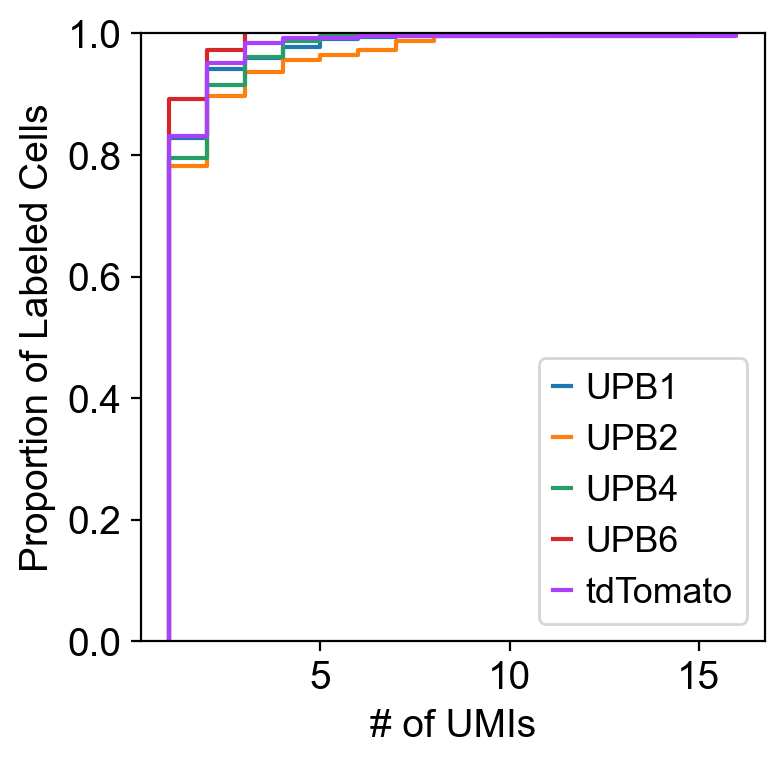

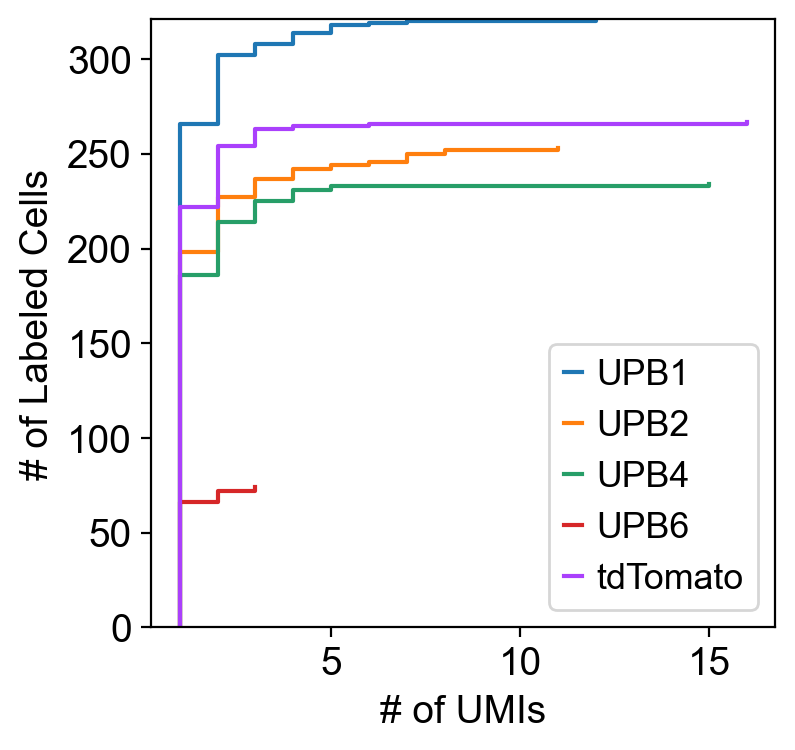

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

upbs = ["UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"] # 

fig, ax = plt.subplots()

for upb in upbs:
    upbs_mask = np.array(adata.obs[upb]) > 0
    adata_upb = adata[upbs_mask, :]
    sns.ecdfplot(data=np.array(adata_upb.obs[upb]))
ax.grid(False)
ax.set_xlabel("# of UMIs")
ax.set_ylabel("Proportion of Labeled Cells")
ax.legend(upbs, loc="lower right")
plt.show(block=False)

fig, ax = plt.subplots()

for upb in upbs:
    upbs_mask = np.array(adata.obs[upb]) > 0
    adata_upb = adata[upbs_mask, :]
    sns.ecdfplot(data=np.array(adata_upb.obs[upb]), stat="count")
ax.grid(False)
ax.set_xlabel("# of UMIs")
ax.set_ylabel("# of Labeled Cells")
ax.legend(upbs, loc="lower right")
plt.show(block=False)

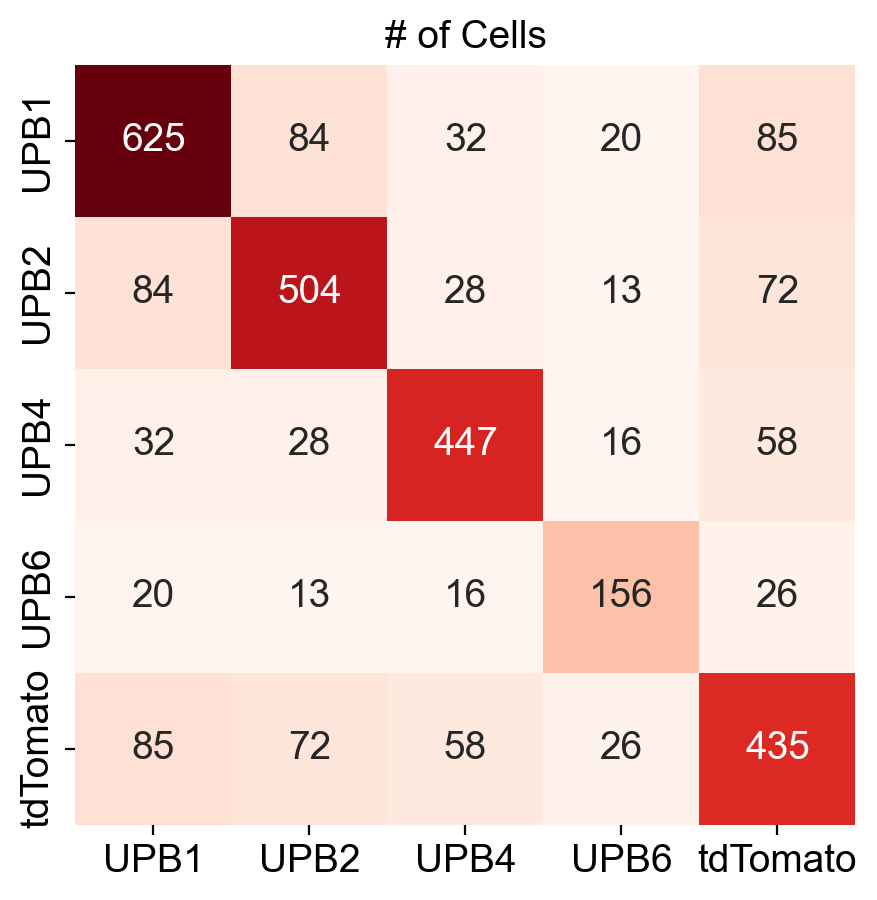

In [8]:
matrix = np.array(adata[:, ["UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"]].X.toarray()) > 0
matrix = matrix.astype(int)
overlap = np.matmul(matrix.T, matrix)

fig, ax = plt.subplots()
sns.heatmap(overlap, cbar=False, annot=True, fmt=".0f", cmap="Reds")
ax.set_title("# of Cells")
ax.set_xticklabels(("UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"))
ax.set_yticklabels(("UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"))
ax.grid(False)
fig.set_size_inches(5, 5)
plt.show(block=False)

In [9]:
sc.pp.filter_cells(adata, min_genes=700)
sc.pp.filter_genes(adata, min_cells=8)

filtered out 257 cells that have less than 700 genes expressed
filtered out 9567 genes that are detected in less than 8 cells


In [10]:
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = 100 * (np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))
adata.obs["n_UMIs"] = np.sum(adata.X, axis=1)

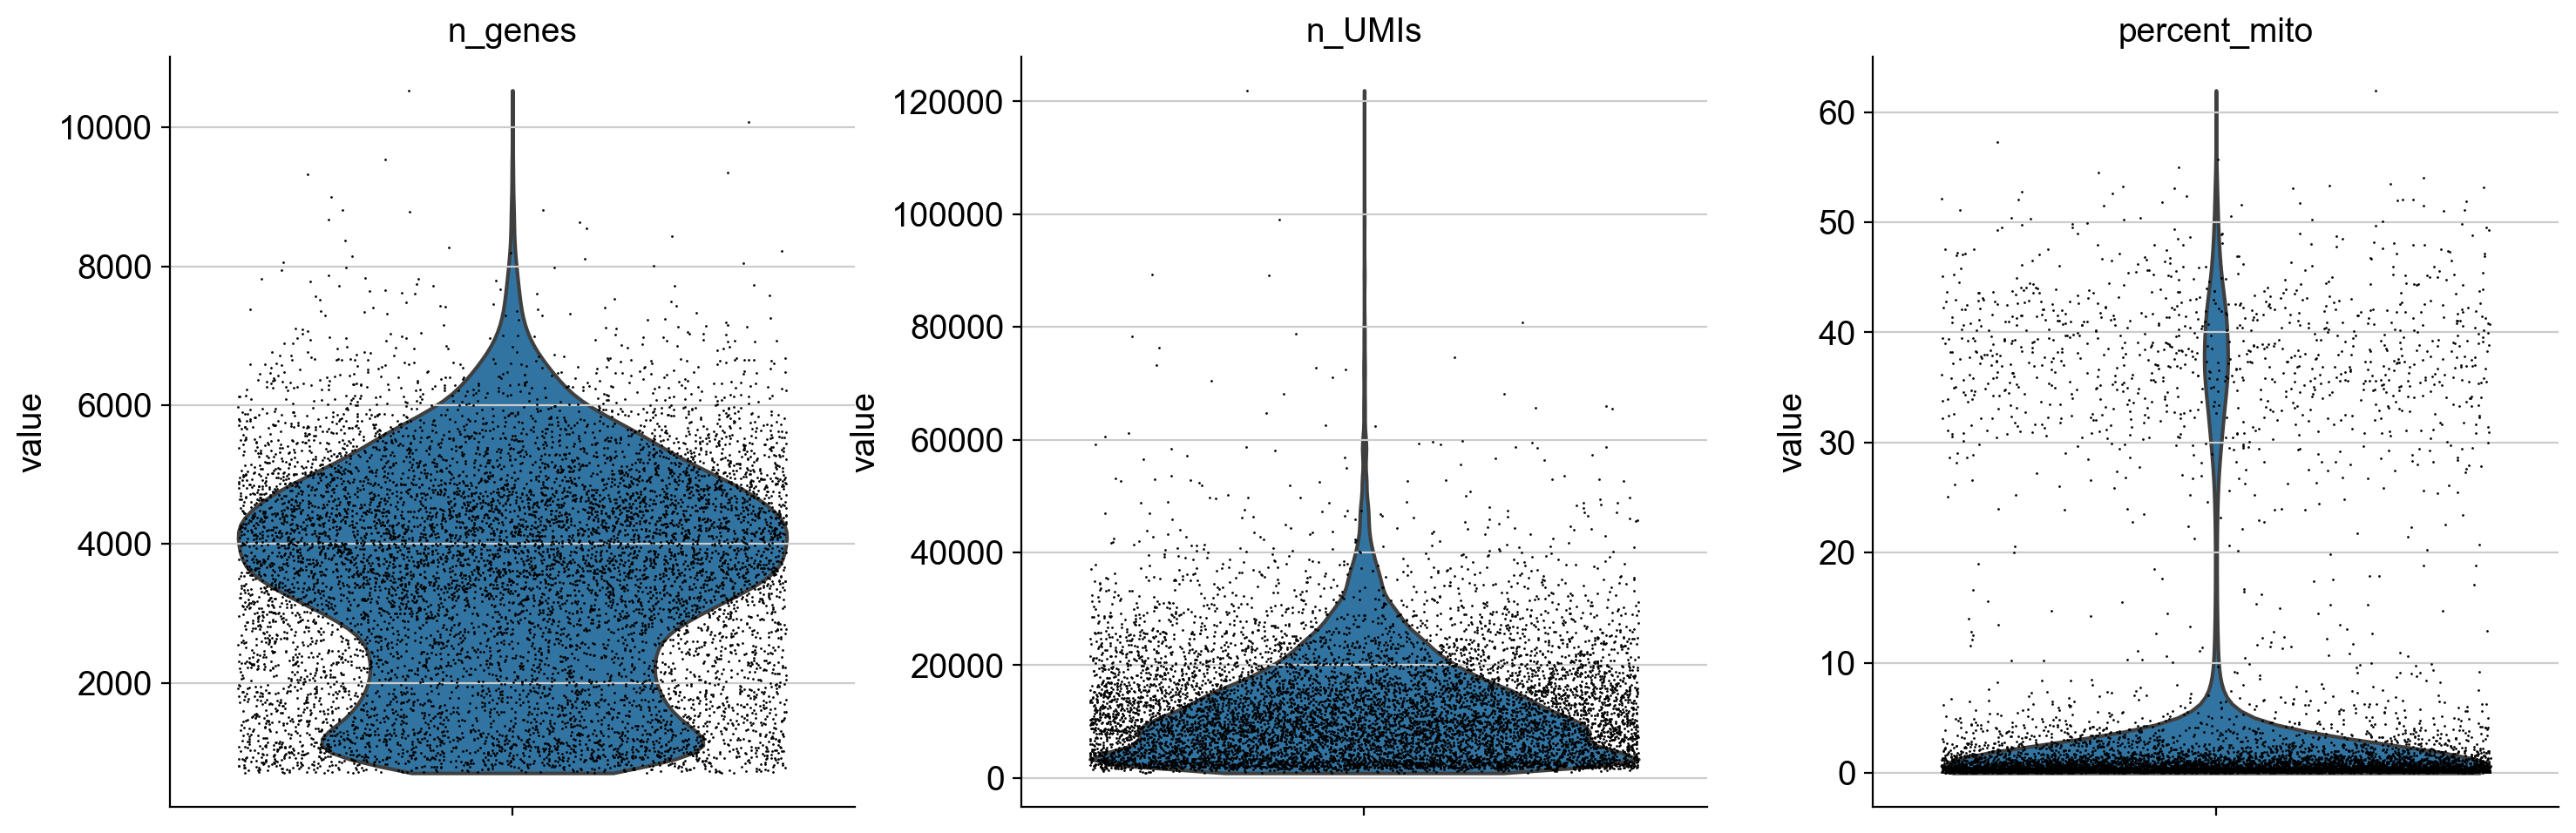

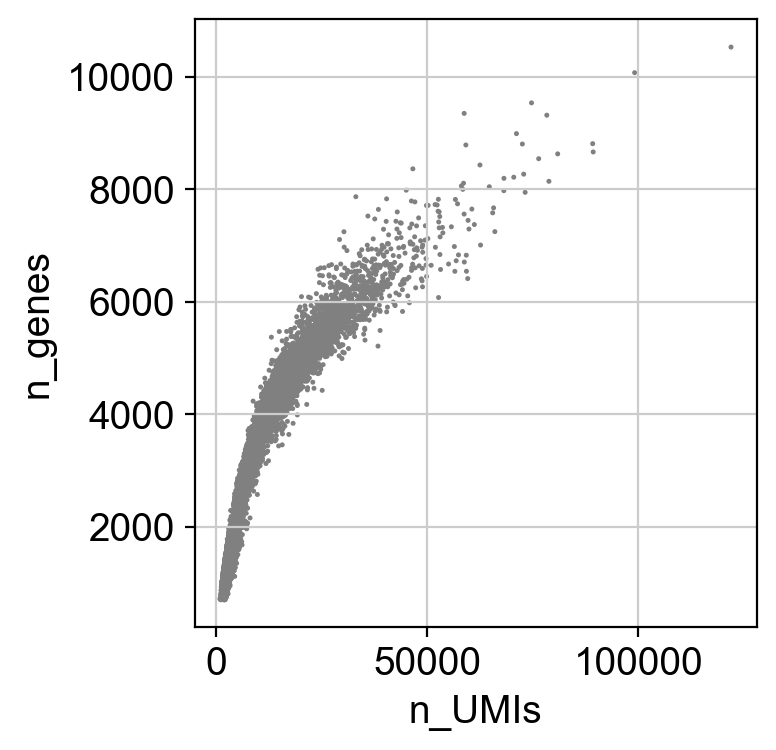

In [11]:
sc.pl.violin(adata, ["n_genes", "n_UMIs", "percent_mito"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="n_UMIs", y="n_genes")

In [12]:
adata = adata[adata.obs.percent_mito < 1, :]
adata = adata[adata.obs["n_genes"] < 6500, :]
adata = adata[adata.obs["n_UMIs"] < 40000, :]

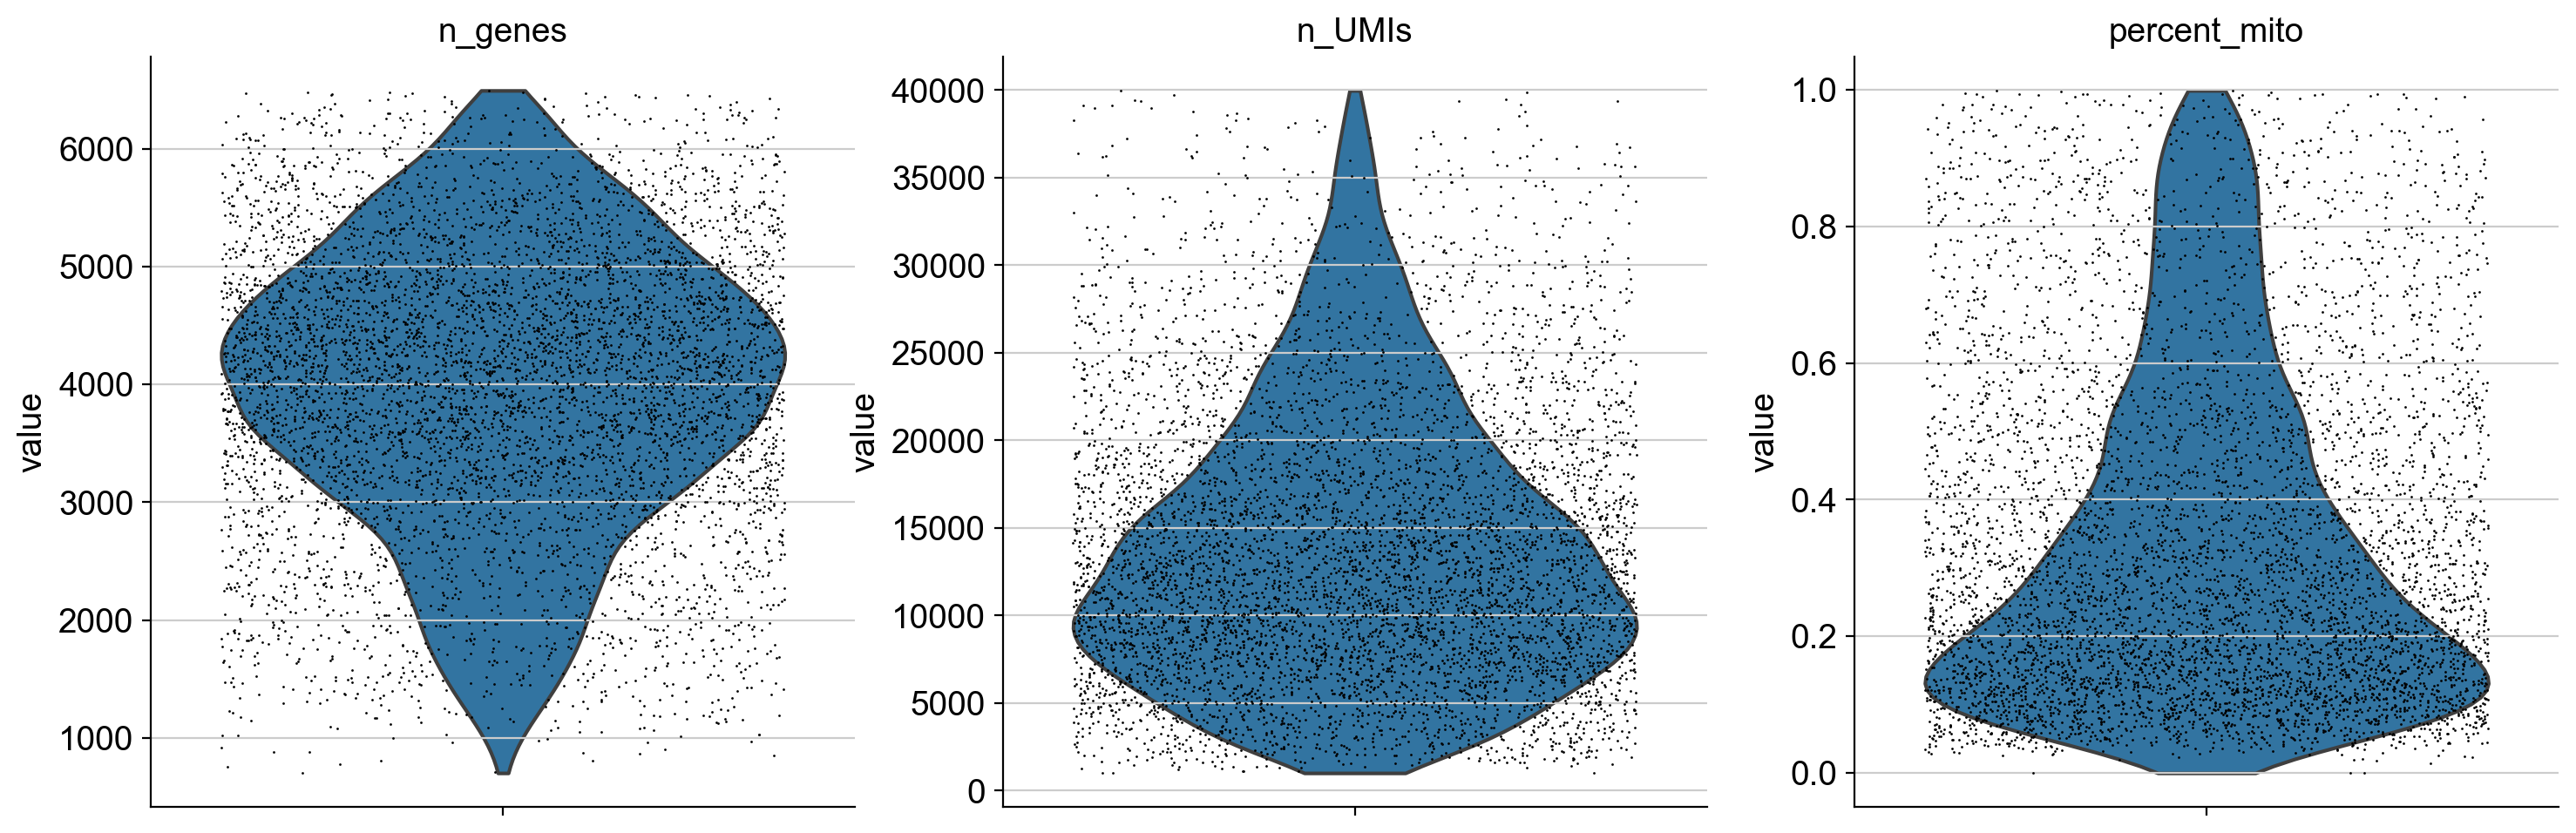

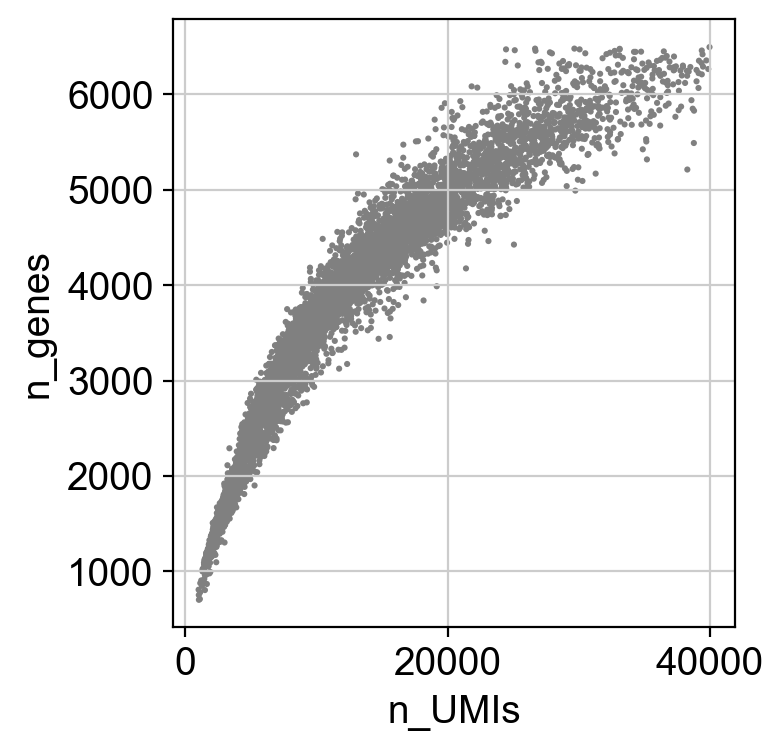

In [13]:
sc.pl.violin(adata, ["n_genes", "n_UMIs", "percent_mito"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="n_UMIs", y="n_genes")

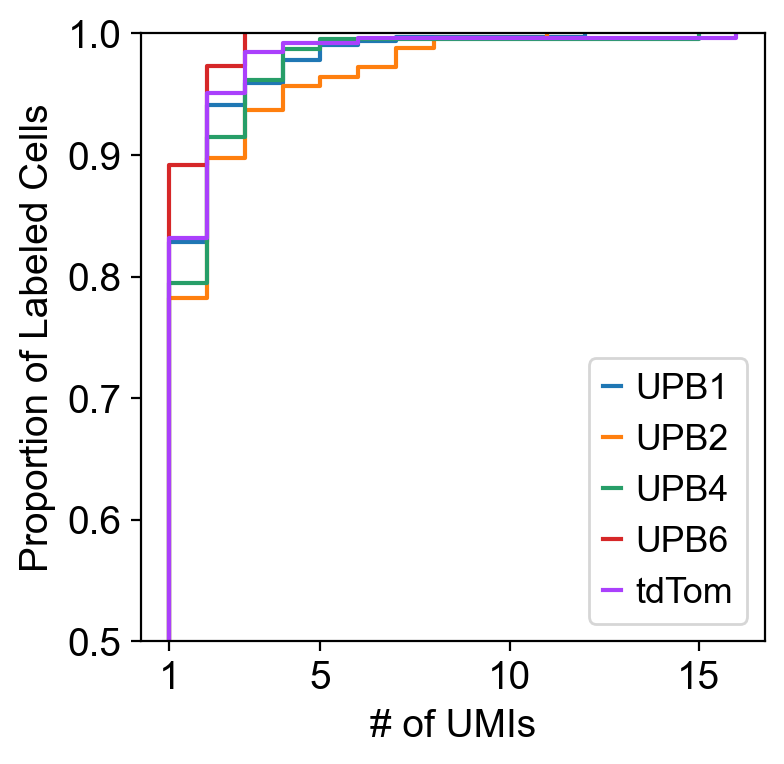

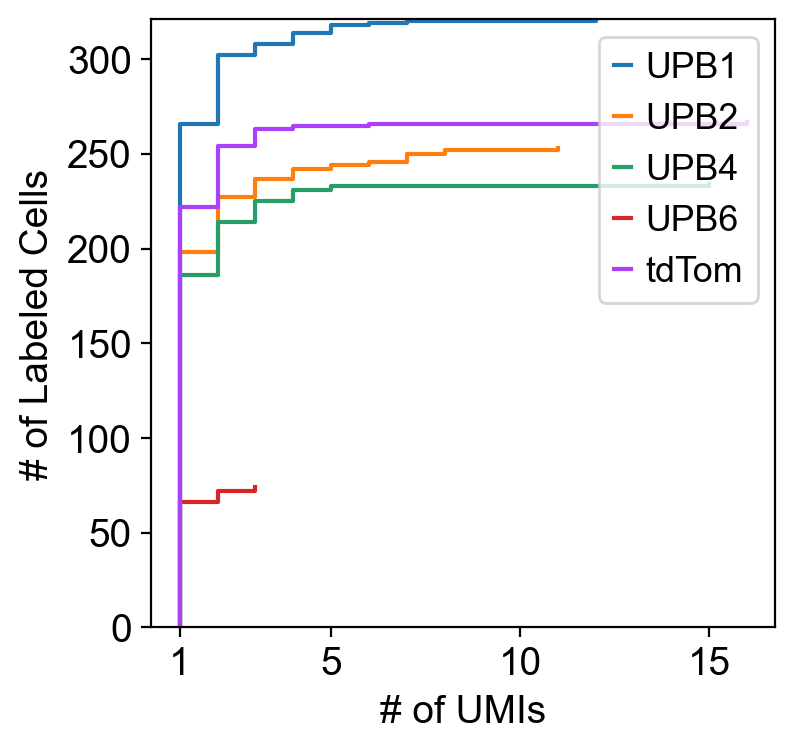

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

upbs = ["UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"]

fig, ax = plt.subplots()

for upb in upbs:
    upbs_mask = np.array(adata.obs[upb]) > 0
    adata_upb = adata[upbs_mask, :]
    sns.ecdfplot(data=np.array(adata_upb.obs[upb]))
ax.grid(False)
ax.set_xticks((1, 5, 10, 15))
ax.set_xlabel("# of UMIs")
ax.set_ylim((0.5, 1))
ax.set_ylabel("Proportion of Labeled Cells")
ax.legend(["UPB1", "UPB2", "UPB4", "UPB6", "tdTom"], loc="lower right")
plt.show(block=False)

fig, ax = plt.subplots()

for upb in upbs:
    upbs_mask = np.array(adata.obs[upb]) > 0
    adata_upb = adata[upbs_mask, :]
    sns.ecdfplot(data=np.array(adata_upb.obs[upb]), stat="count")
ax.grid(False)
ax.set_xticks((1, 5, 10, 15))
ax.set_xlabel("# of UMIs")
ax.set_ylabel("# of Labeled Cells")
ax.legend(["UPB1", "UPB2", "UPB4", "UPB6", "tdTom"], loc="upper right")
plt.show(block=False)

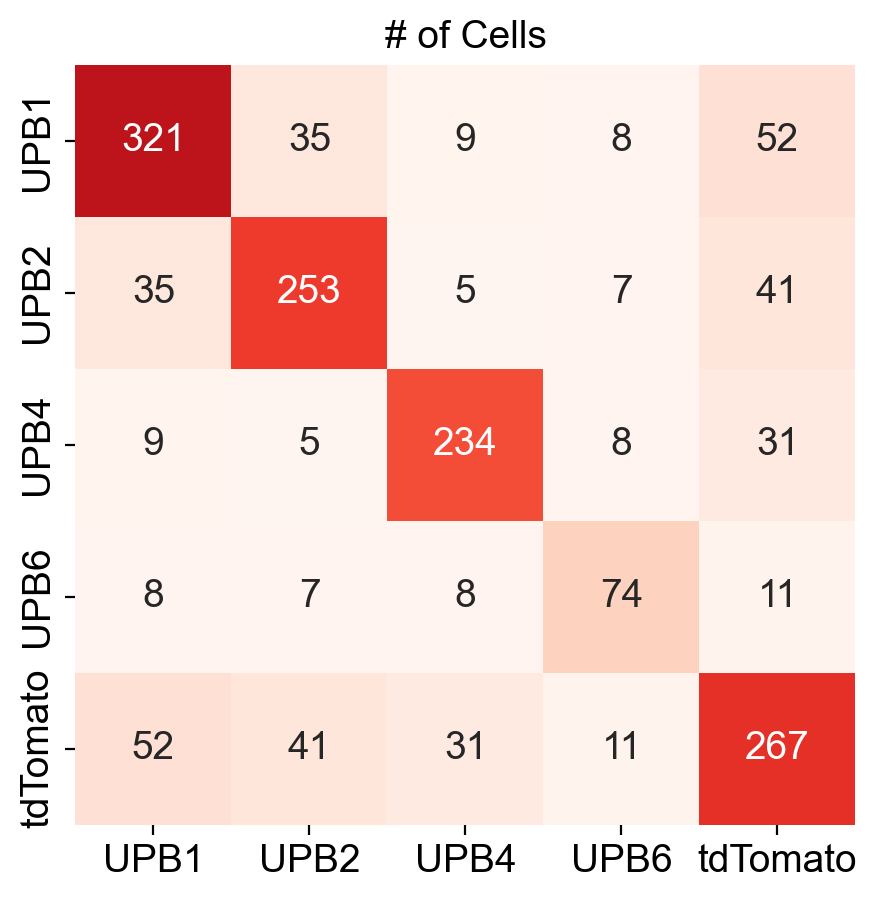

In [15]:
matrix = np.array(adata[:, ["UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"]].X.toarray()) > 0
matrix = matrix.astype(int)
overlap = np.matmul(matrix.T, matrix)

fig, ax = plt.subplots()
sns.heatmap(overlap, cbar=False, annot=True, fmt=".0f", cmap="Reds", vmax=400)
ax.set_title("# of Cells")
ax.set_xticklabels(("UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"))
ax.set_yticklabels(("UPB1", "UPB2", "UPB4", "UPB6", "tdTomato"))
ax.grid(False)
fig.set_size_inches(5, 5)
plt.show(block=False)

In [16]:
adata.obs["doublet"] = adata.obs["doublet"].astype(str)
adata.obs["LM"] = adata.obs["LM"].astype(str)
adata.obs["RL"] = adata.obs["RL"].astype(str)
genes = [g for g in adata.var_names if g not in ["UPB1", "UPB2", "UPB4", "UPB6", "WPRE", "tdTomato"]]
adata = adata[:, genes]
adata.write_h5ad("E:/Mouse_V1/projection_seq_split.h5ad")

C:\Users\TLab\AppData\Local\Temp\ipykernel_7984\3482619718.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet"] = adata.obs["doublet"].astype(str)
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [17]:
adata_raw = adata.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


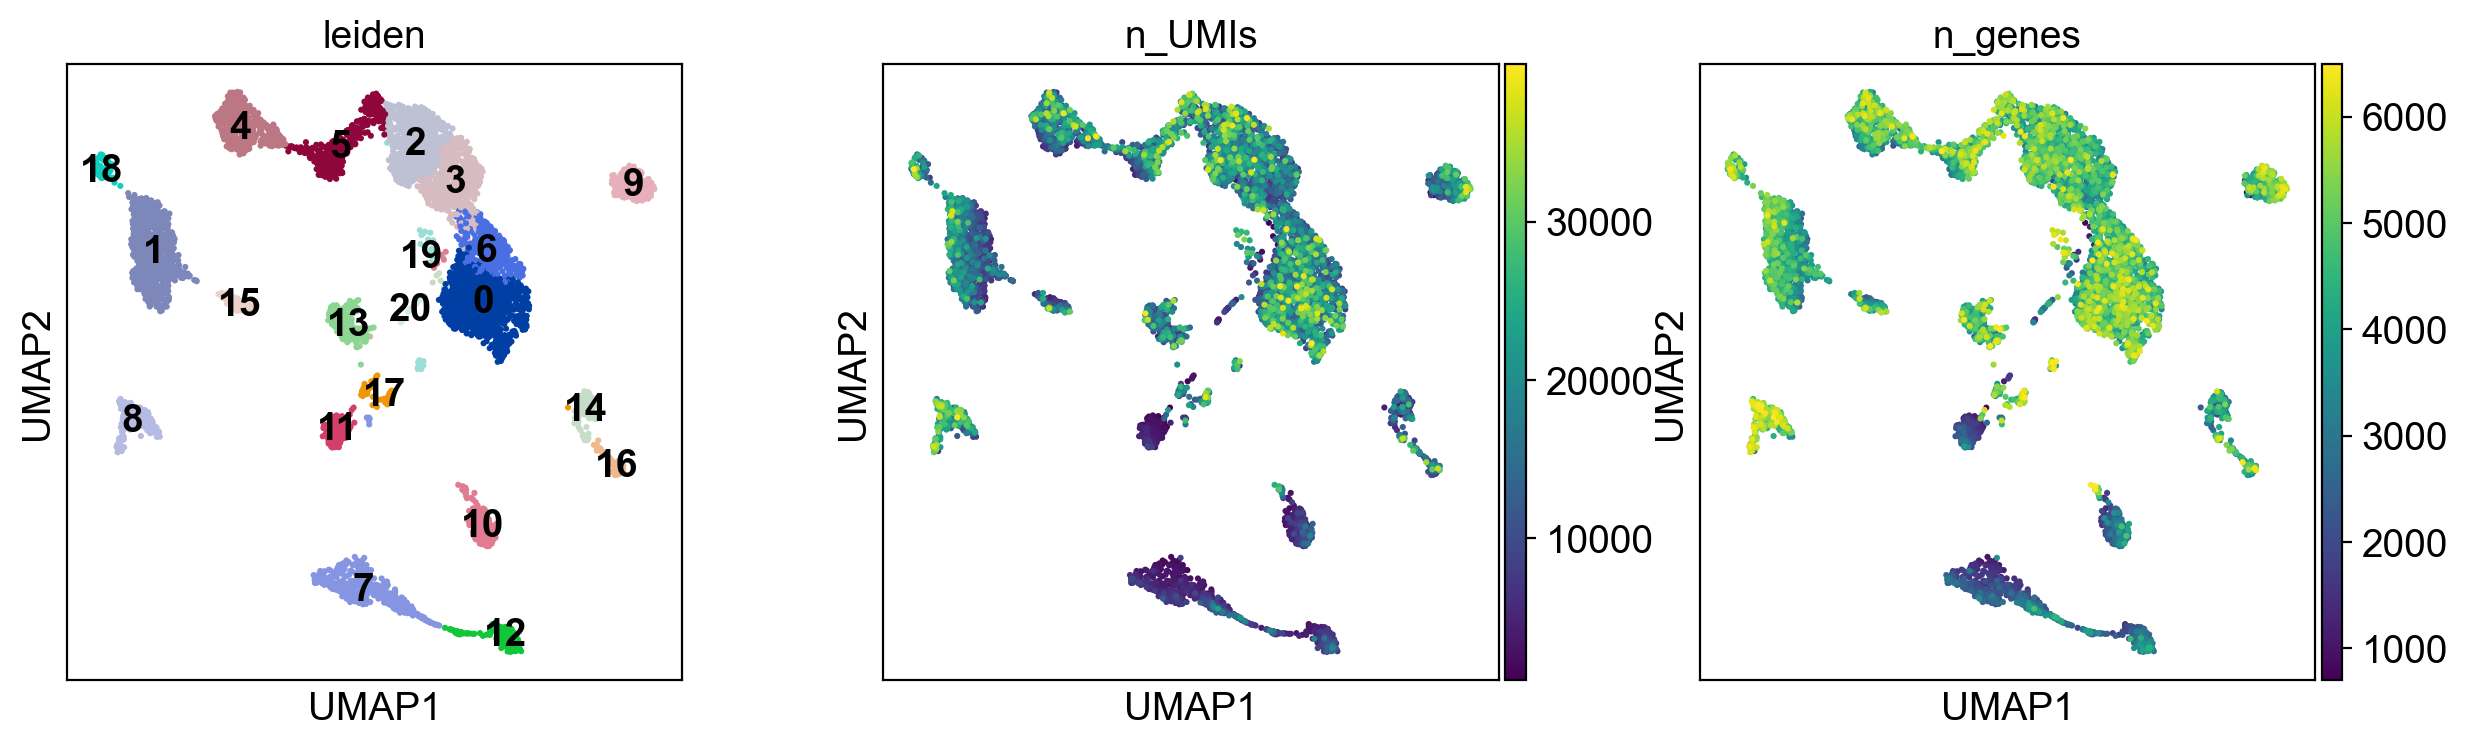

In [18]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "n_UMIs", "n_genes"], legend_loc="on data")

Check that Samples are Well-Mixed among Clusters

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


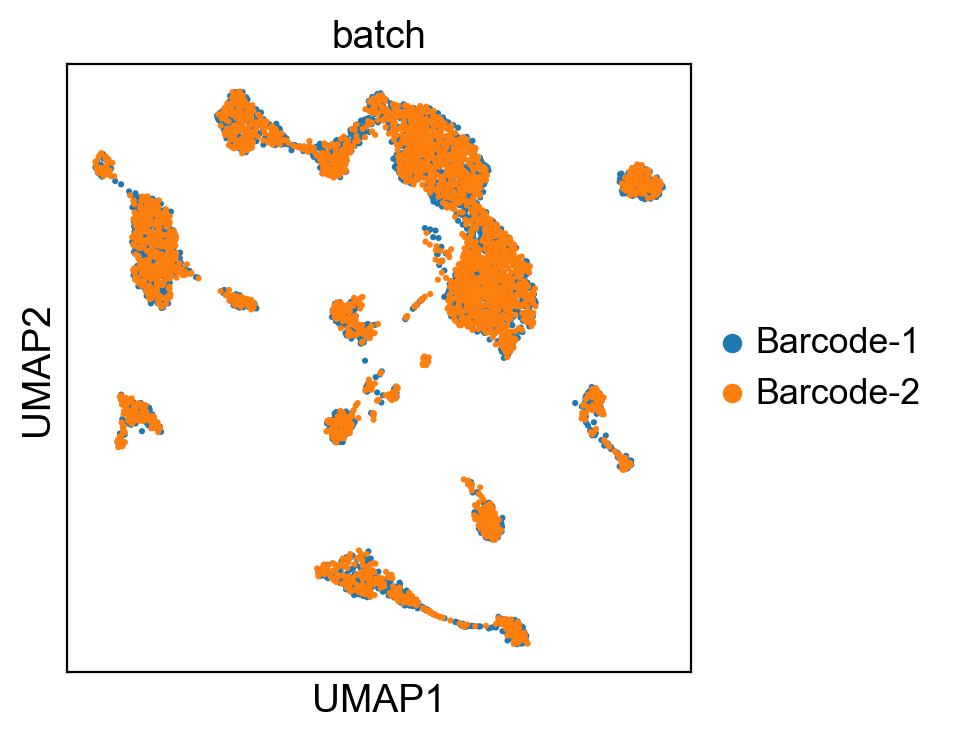

In [19]:
sc.pl.umap(adata, color=["batch"])

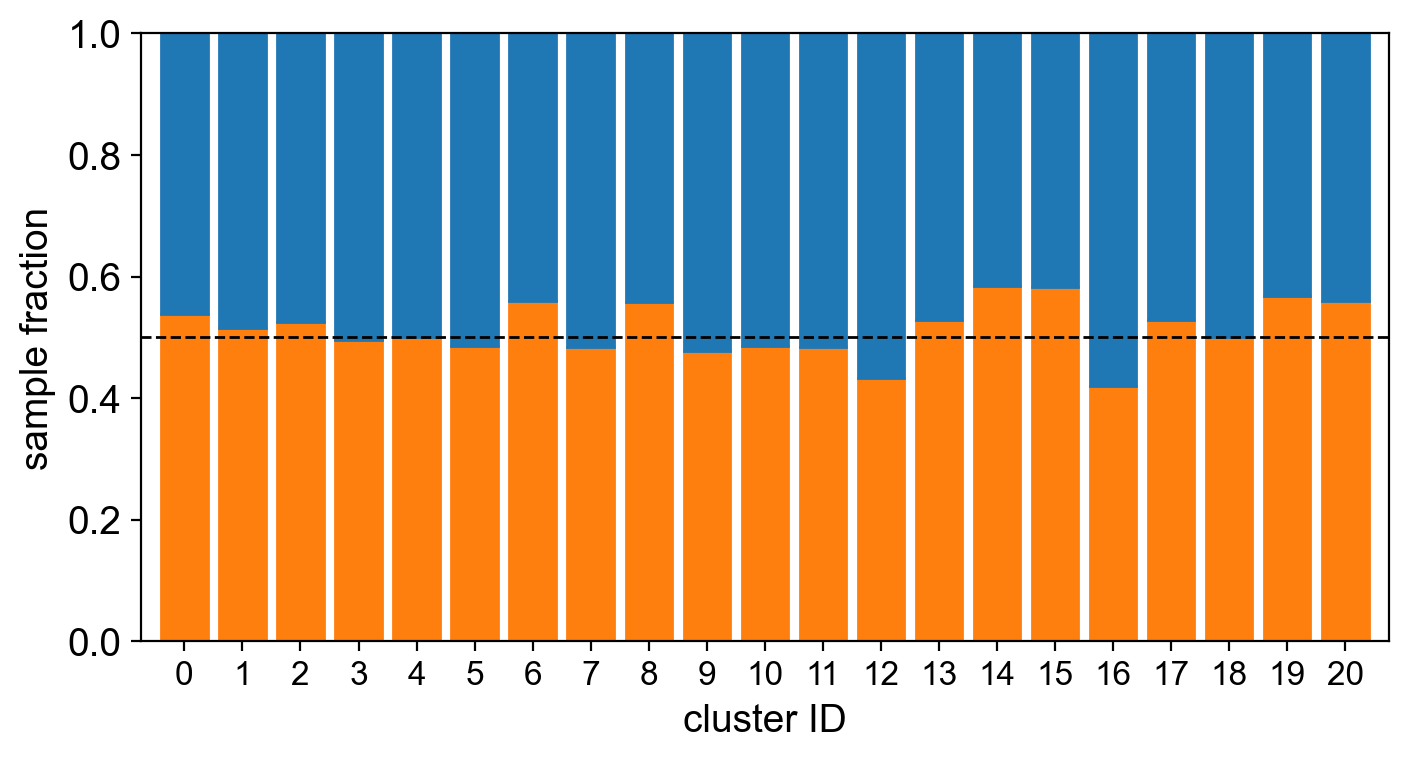

In [20]:
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
sample_fractions = []
for sample in sample_IDs[::-1]:
    sf = []
    for cluster in cluster_ids:
        adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
        sf.append(np.sum(adata_clust.obs["batch"] == sample) / adata_clust.shape[0])
    sample_fractions.append(sf)

fig, ax = plt.subplots()
bottom = np.zeros(len(cluster_ids))
for sf, col in zip(sample_fractions, adata.uns["batch_colors"][::-1]):
    ax.bar(cluster_ids, sf, color=col, edgecolor=col, bottom=bottom)
    bottom += np.array(sf)
ax.hlines(0.5, -1, np.max(cluster_ids) + 1, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("sample fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

Read Doublet-Scored Data and Examine Clusters for Artifacts

In [21]:
accum_adata, cell_count = [], 0
for sample in sample_IDs:
    pre_path = data_path + sample + ".h5ad"
    temp_adata = sc.read_h5ad(
        pre_path,
                              )
    temp_adata.var_names_make_unique()
    accum_adata.append(temp_adata)
    cell_count += temp_adata.n_obs

pre_adata = accum_adata[0].concatenate(*accum_adata[1:], batch_categories=sample_IDs)

adata.obs["doublet"] = pre_adata.obs["doublet"]
adata.obs["doublet_score"] = pre_adata.obs["doublet_score"]

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


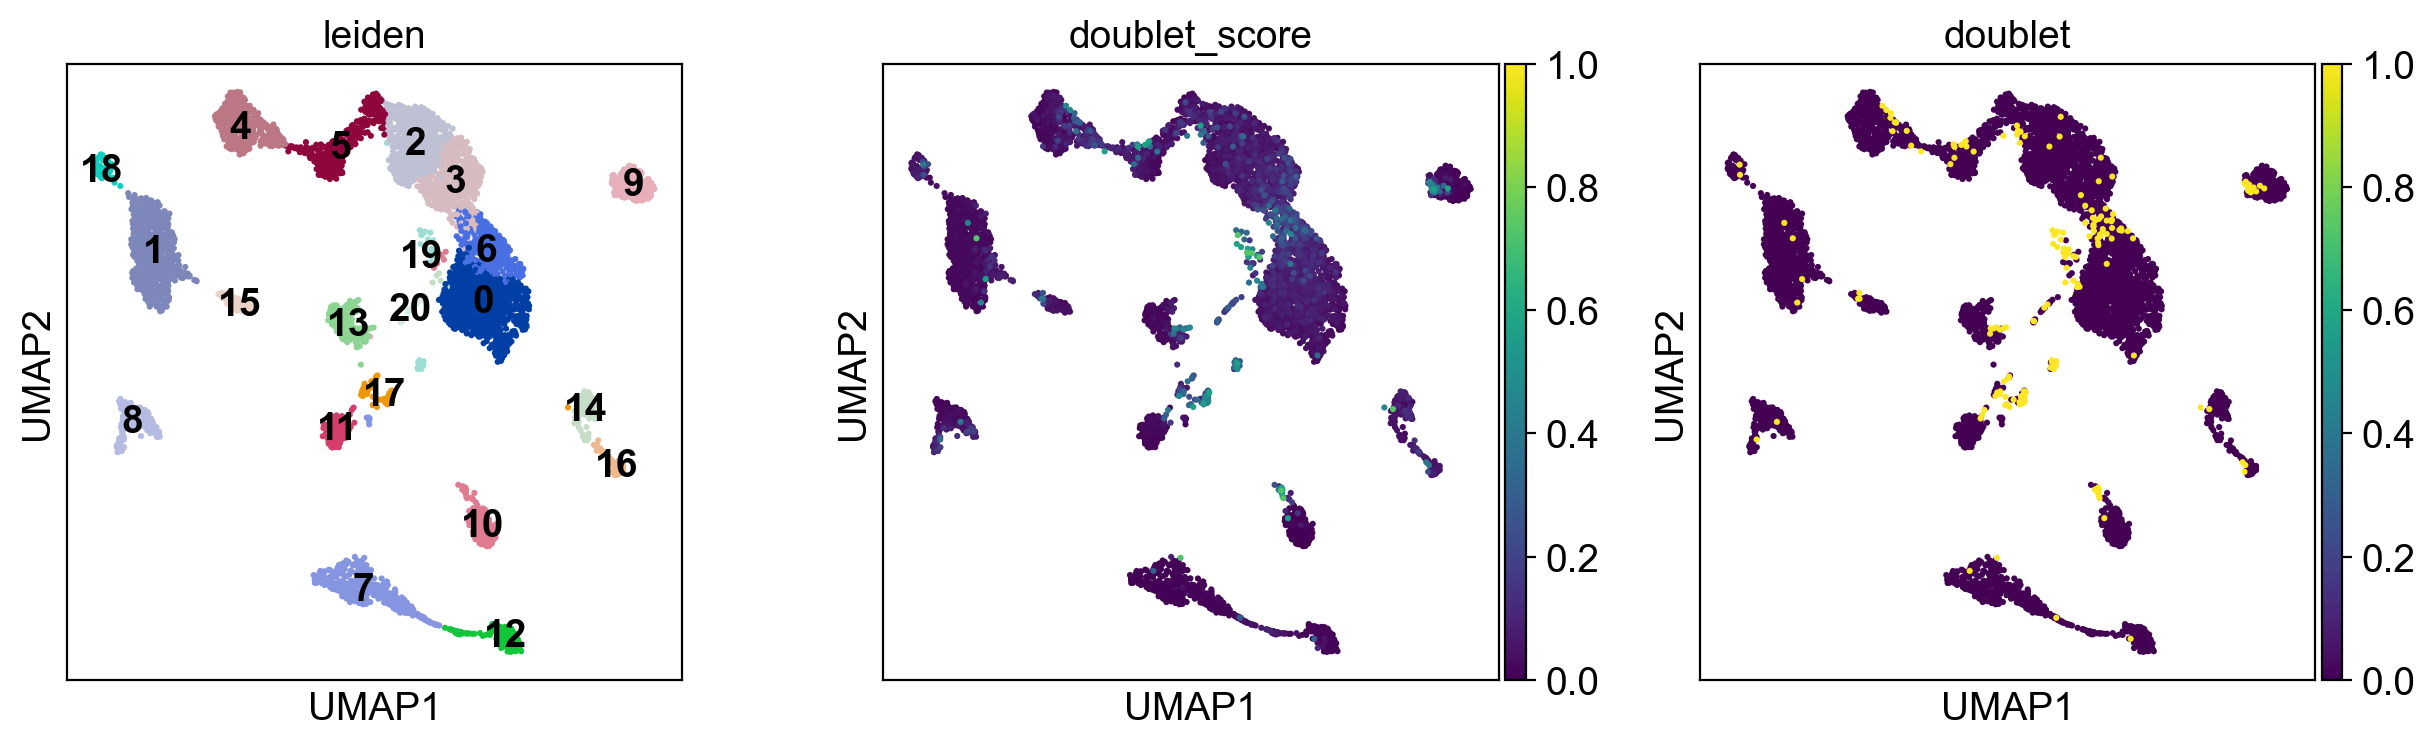

In [22]:
adata.obs["doublet"] = adata.obs["doublet"] - 0 # Convert boolean to integer for plotting
sc.pl.umap(adata, color=["leiden", "doublet_score", "doublet"], legend_loc="on data", vmin=0, vmax=1)

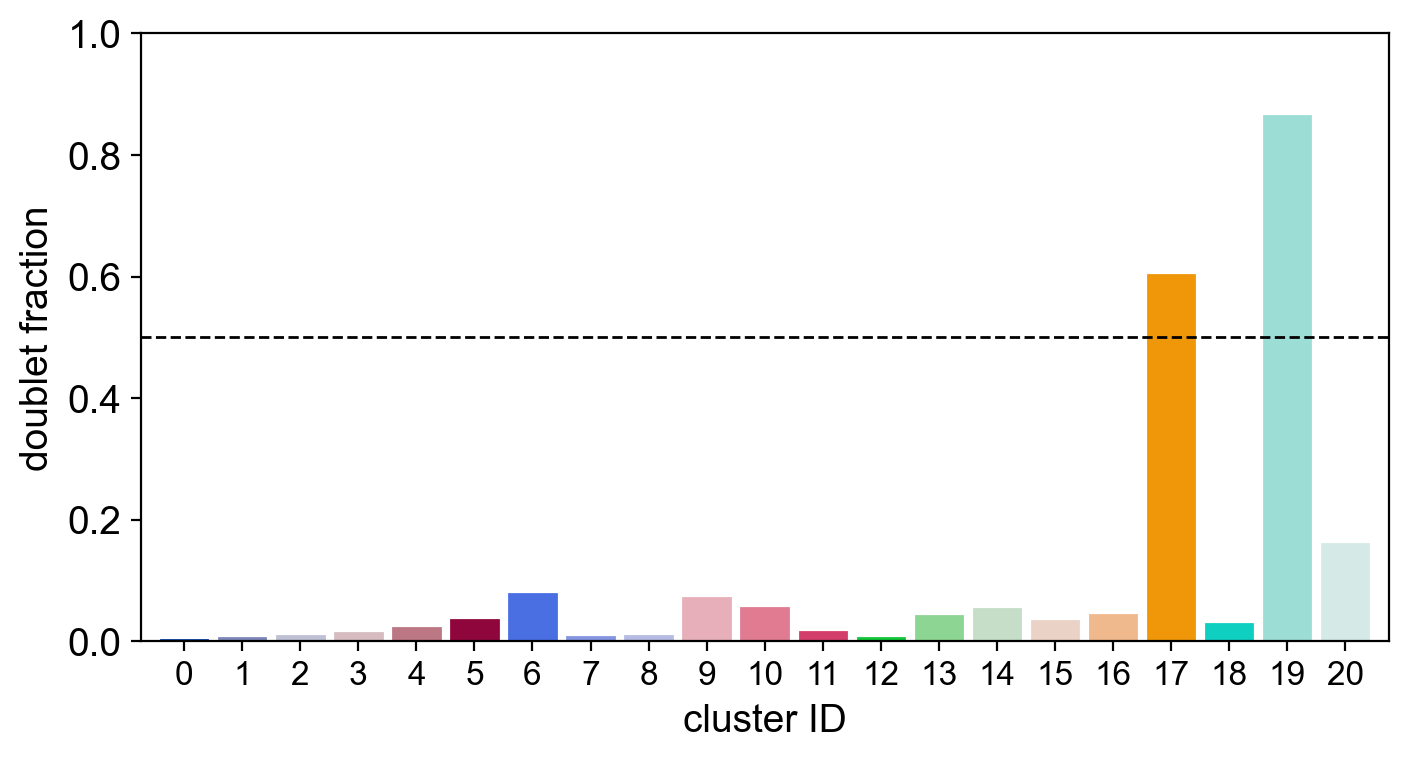

In [23]:
doublet_fraction = []
for cluster in cluster_ids:
    adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
    doublet_fraction.append(np.sum(adata_clust.obs["doublet"]) / adata_clust.shape[0])

fig, ax = plt.subplots()
ax.bar(cluster_ids, doublet_fraction, color=adata.uns["leiden_colors"], edgecolor=adata.uns["leiden_colors"])
ax.hlines(0.5, -1, np.max(cluster_ids) + 1, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("doublet fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

Look for Marker Genes and Identify Ambiguous Clusters

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


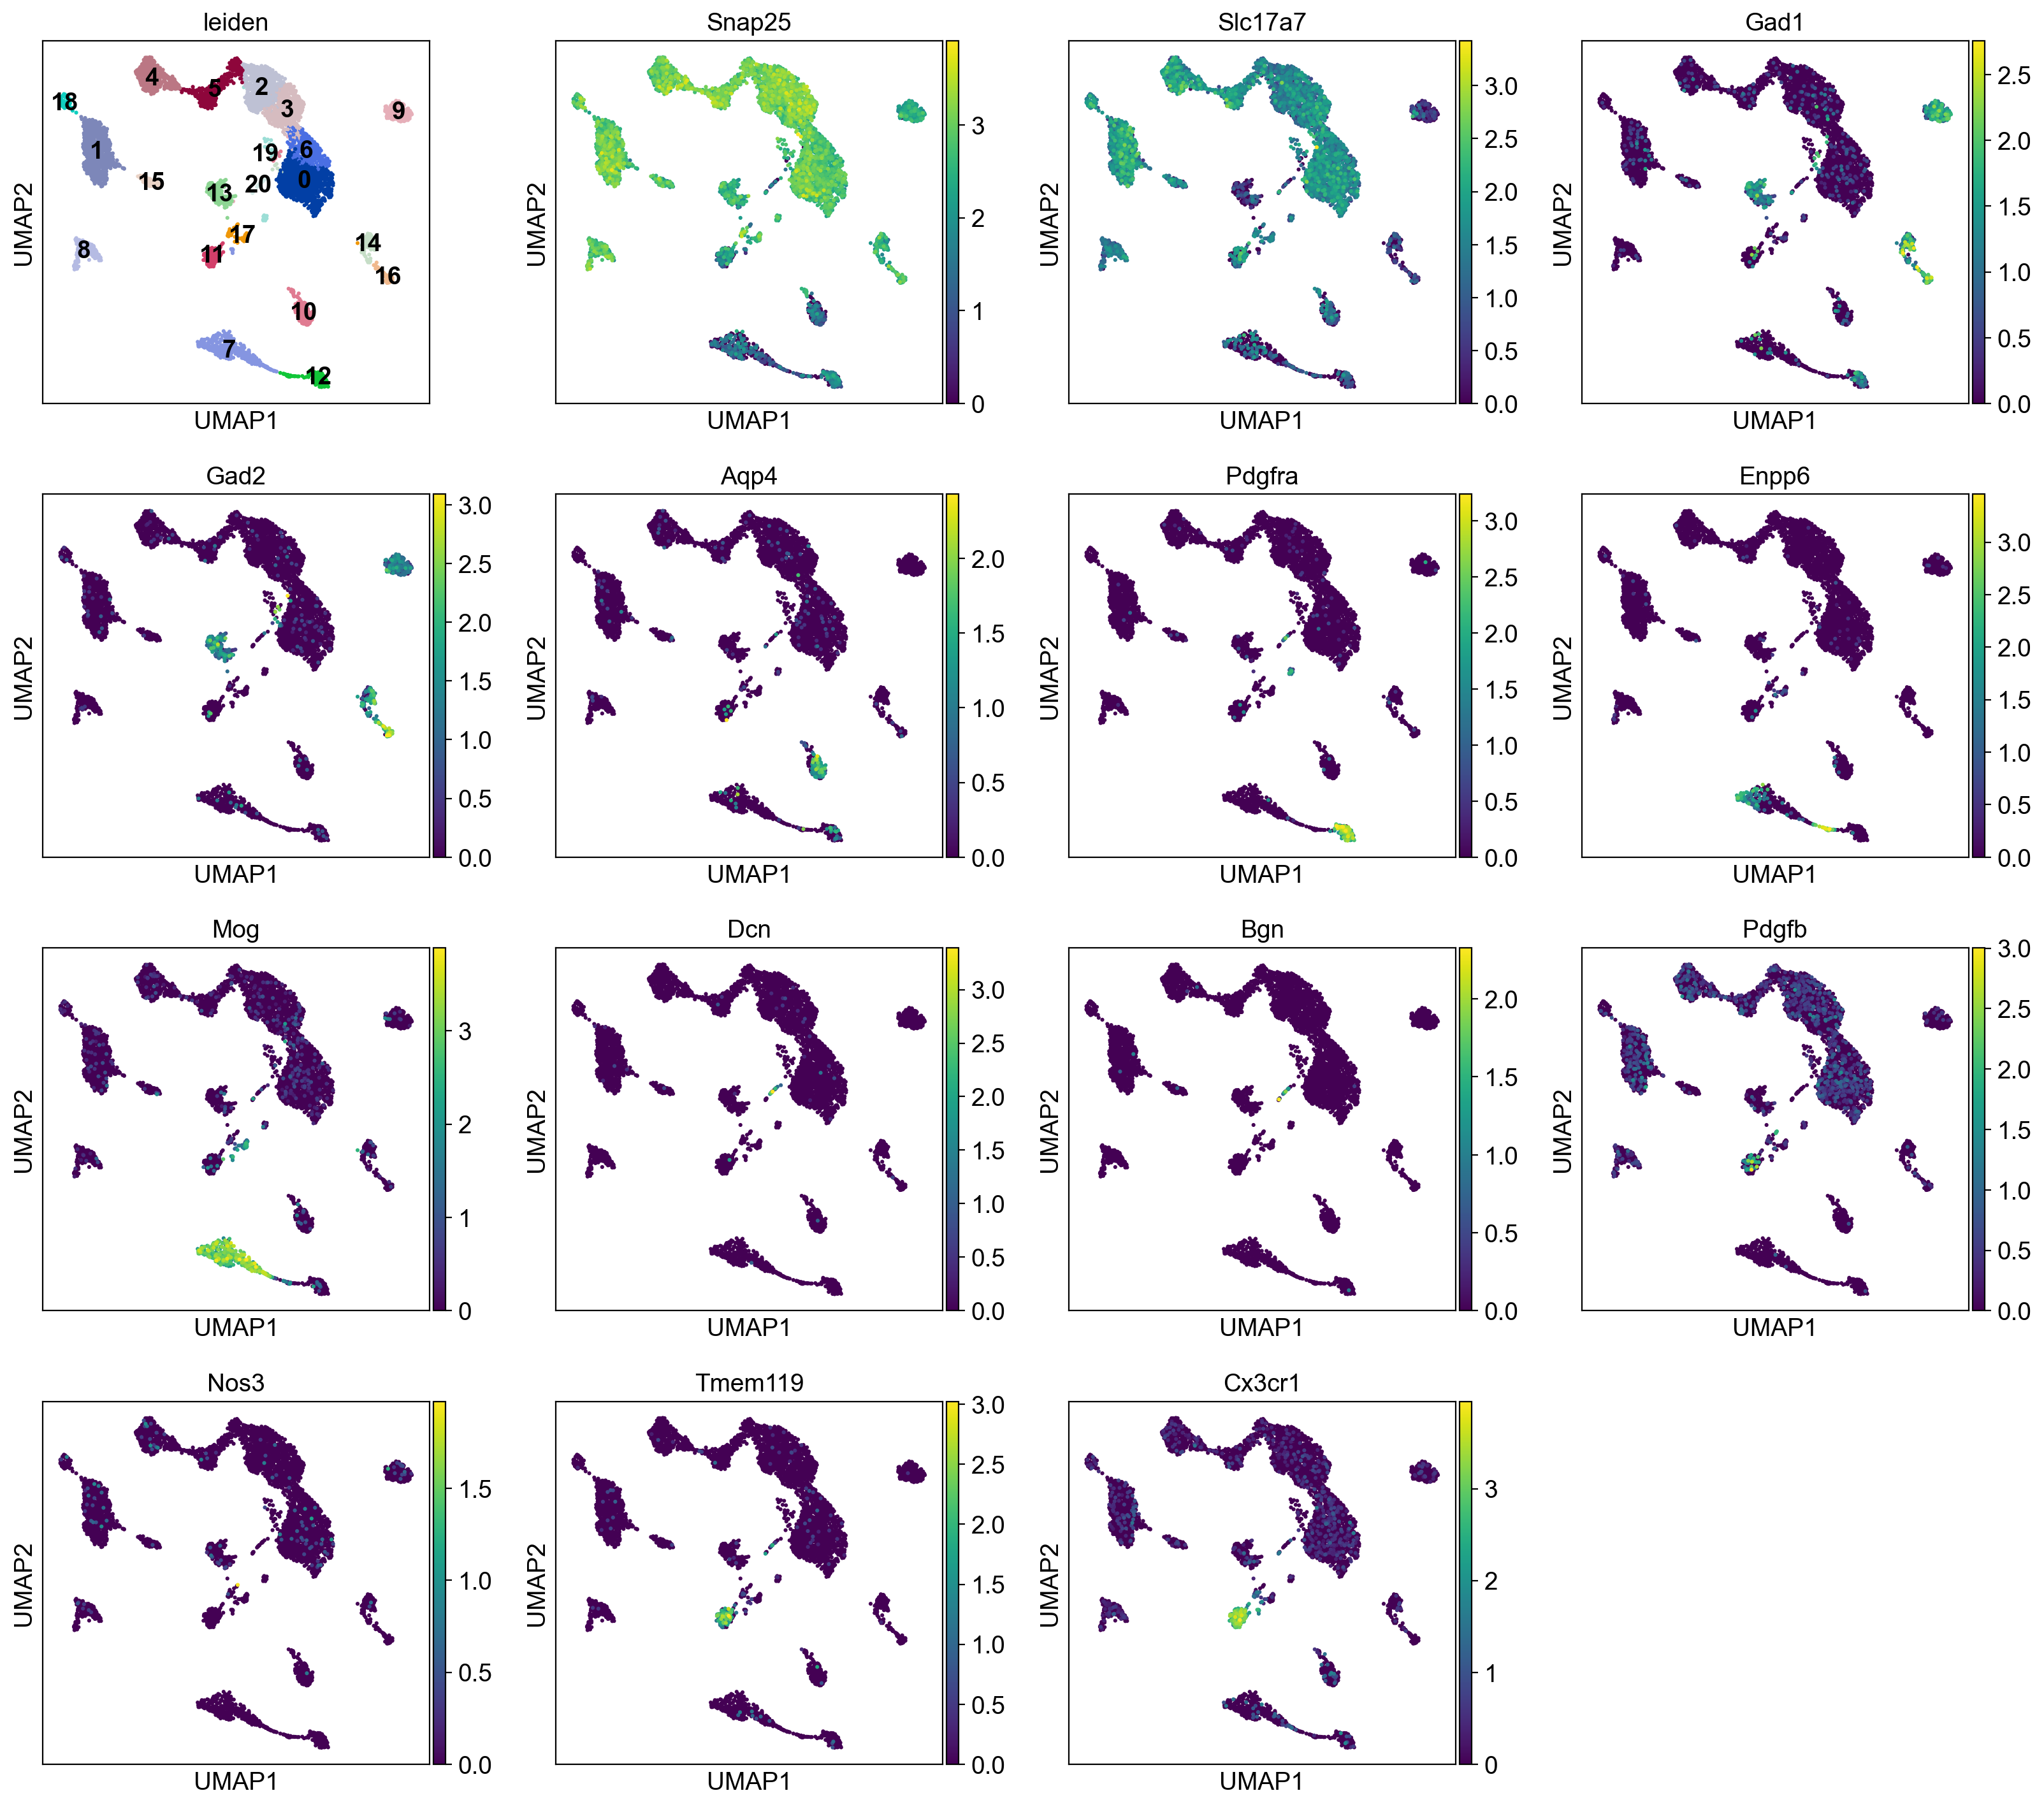

In [24]:
class_markers = [
                 "Snap25", "Slc17a7", # glutamatergic neurons
                 "Gad1", "Gad2", # GABAergic neurons
                 "Aqp4", # astrocytes
                 "Pdgfra", # OPCs
                 "Enpp6", "Mog", # oligodendrocytes
                 "Dcn", "Bgn", # vascular & leptomeningeal cells
                 "Pdgfb", "Nos3", # endothelial cells
                 "Tmem119", "Cx3cr1", # microglia
                ]

sc.pl.umap(adata, color=["leiden"] + class_markers, legend_loc="on data")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


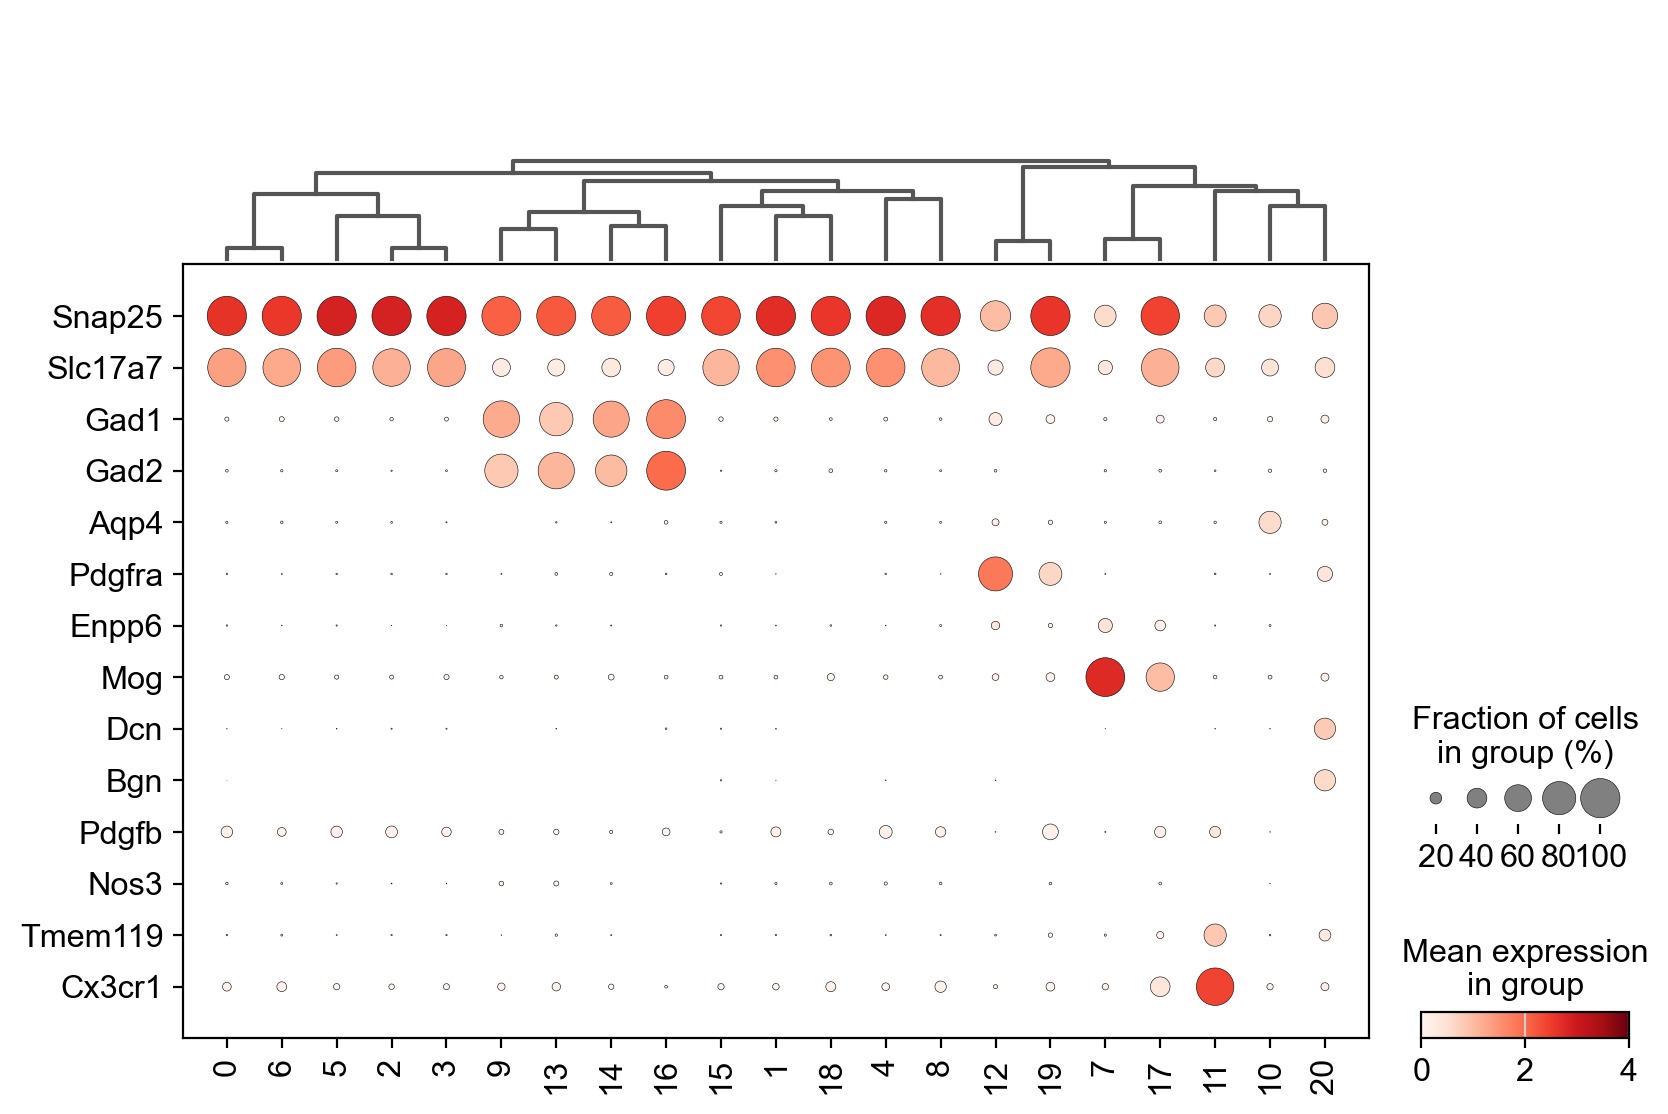

In [25]:
sc.pl.dotplot(adata, class_markers, groupby="leiden", swap_axes=True, dendrogram=True, vmin=0, vmax=4)

In [26]:
class_idx = {
        "glutamatergic" : ["0", "1", "2", "3", "4", "5", "6", "8", "15", "18"], 
        "GABAergic" : ["9", "13", "14", "16"], 
        "non-neuronal" : ["7", "10", "11", "12", "20"], 
        "ambiguous" : ["17", "19"], 
            }

adata.obs["class"] = [None] * adata.shape[0]

for name, idx in class_idx.items():
    mask = np.isin(adata.obs["leiden"], idx)
    adata.obs.loc[mask, "class"] = [name] * np.sum(mask)

In [27]:
adata

AnnData object with n_obs × n_vars = 6099 × 21077
    obs: 'batch', 'doublet', 'doublet_score', 'UPB1', 'UPB2', 'UPB4', 'UPB6', 'LM', 'RL', 'UPBs', 'VISs', 'TGs', 'tdTomato', 'n_genes', 'percent_mito', 'n_UMIs', 'n_counts', 'leiden', 'class'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'batch_colors', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


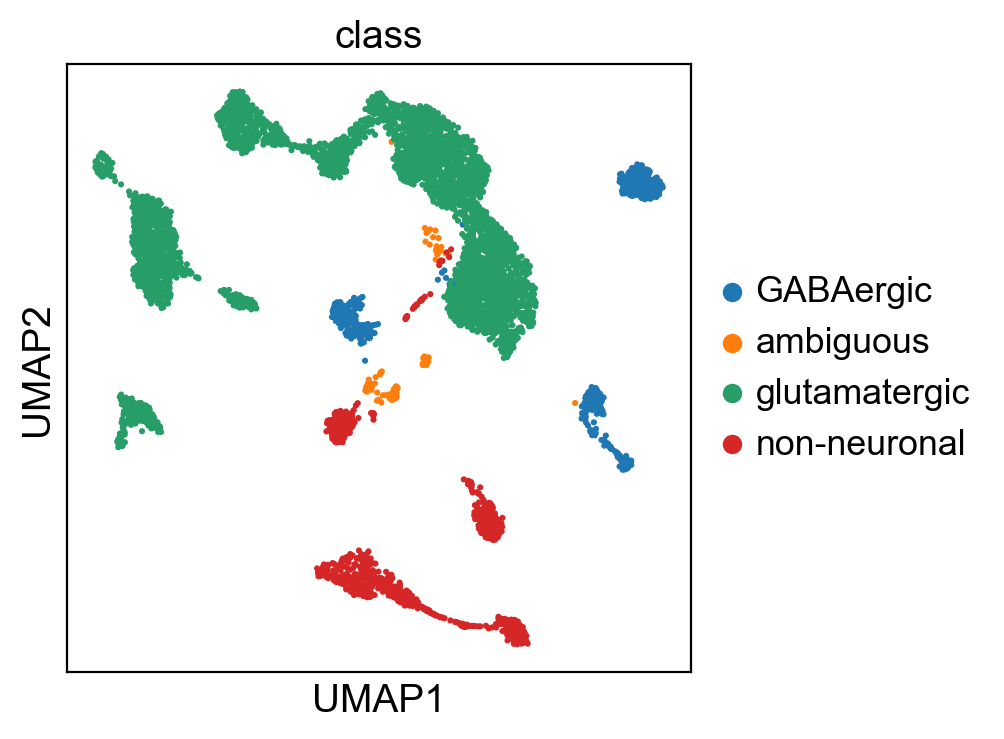

In [28]:
sc.pl.umap(adata, color=["class"])

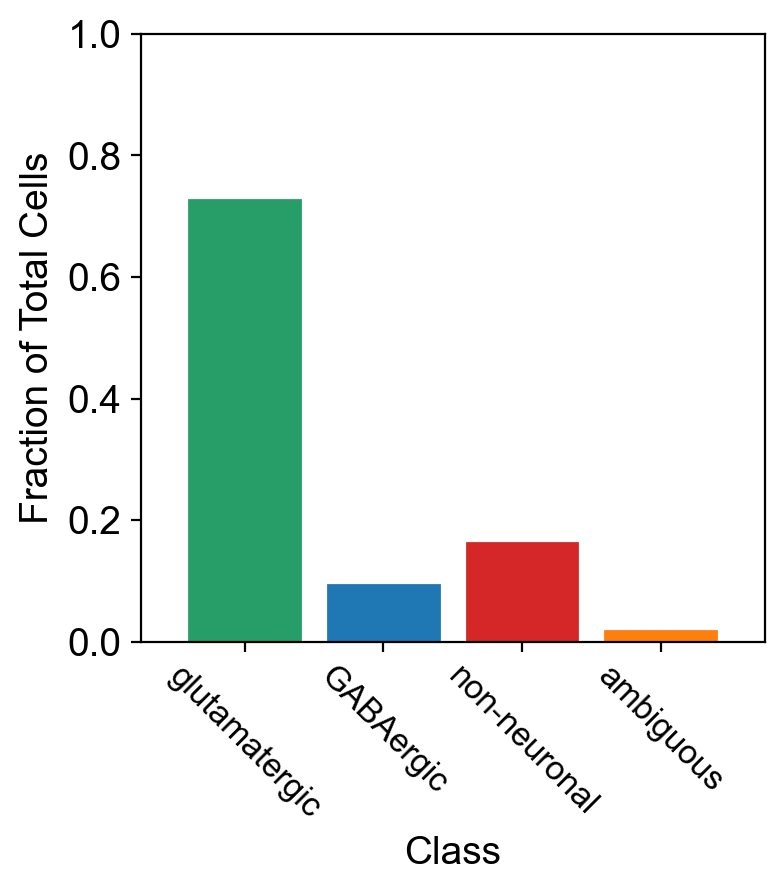

In [29]:
class_ids = ["glutamatergic", "GABAergic", "non-neuronal", "ambiguous"]
class_fractions = []
for clss in class_ids:
    class_fractions.append(np.sum(adata.obs["class"] == clss) / adata.shape[0])

fig, ax = plt.subplots()
col = [adata.uns["class_colors"][idx] for idx in [2, 0, 3, 1]]
ax.bar(class_ids, class_fractions, color=col, edgecolor=col)
ax.set_xlabel("Class")
ax.set_xlim((-0.75, len(class_ids) - 0.25))
ax.set_xticks(class_ids)
ax.set_xticklabels(class_ids, fontsize=12, rotation=-45)
ax.set_ylabel("Fraction of Total Cells")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(4, 4)
plt.show(block=False)

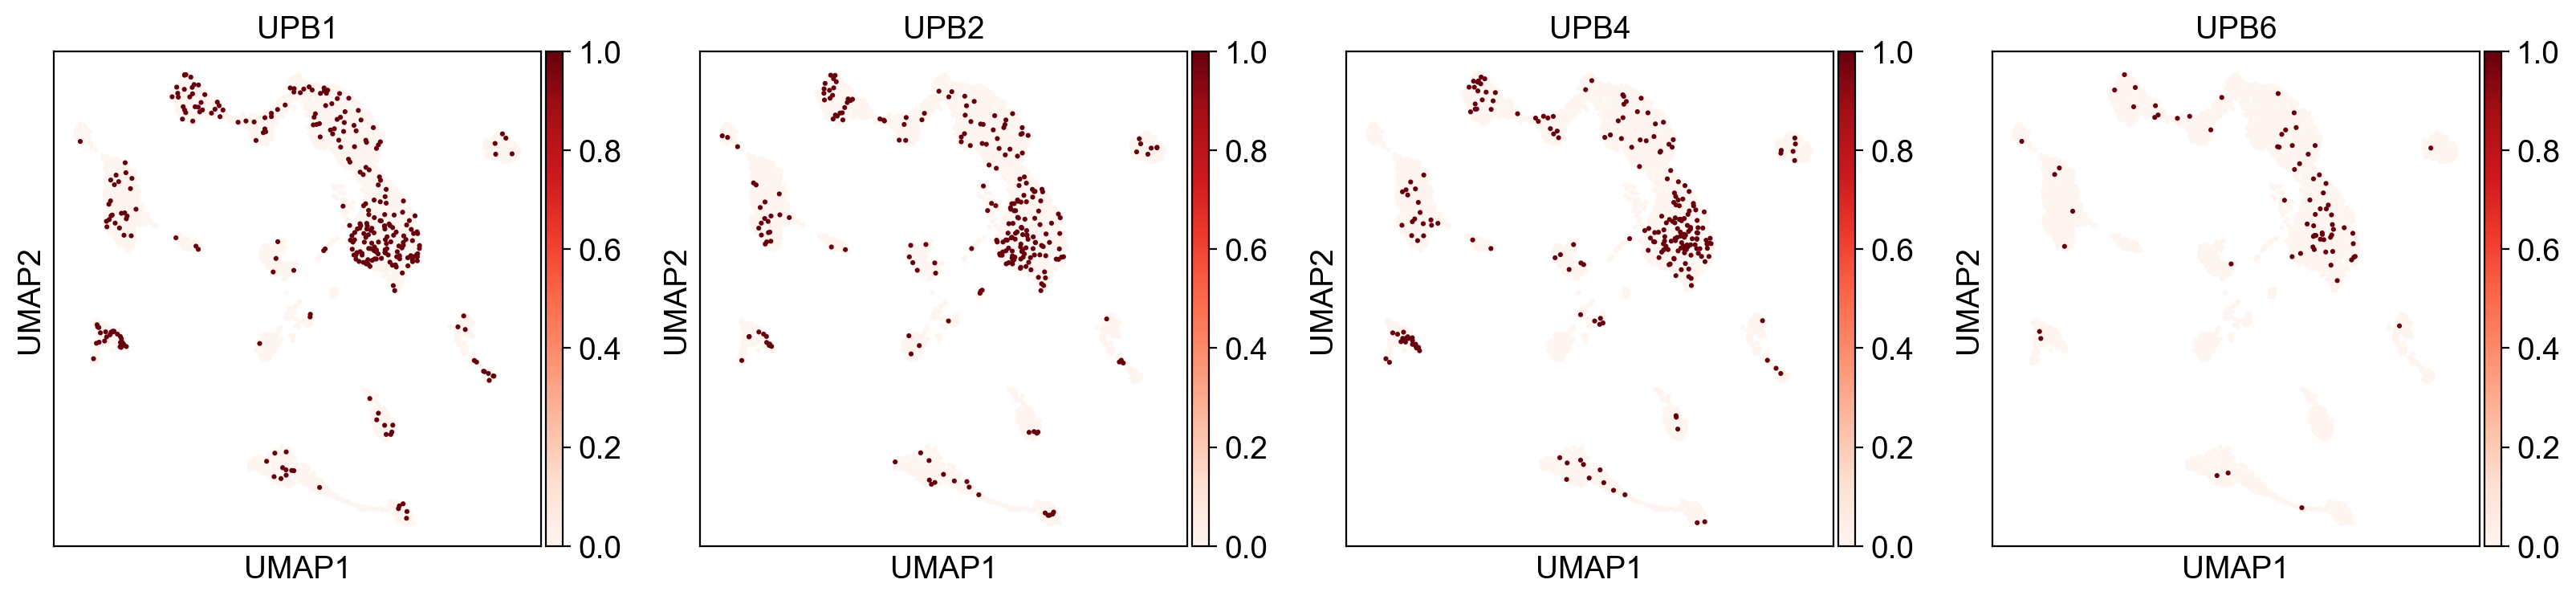

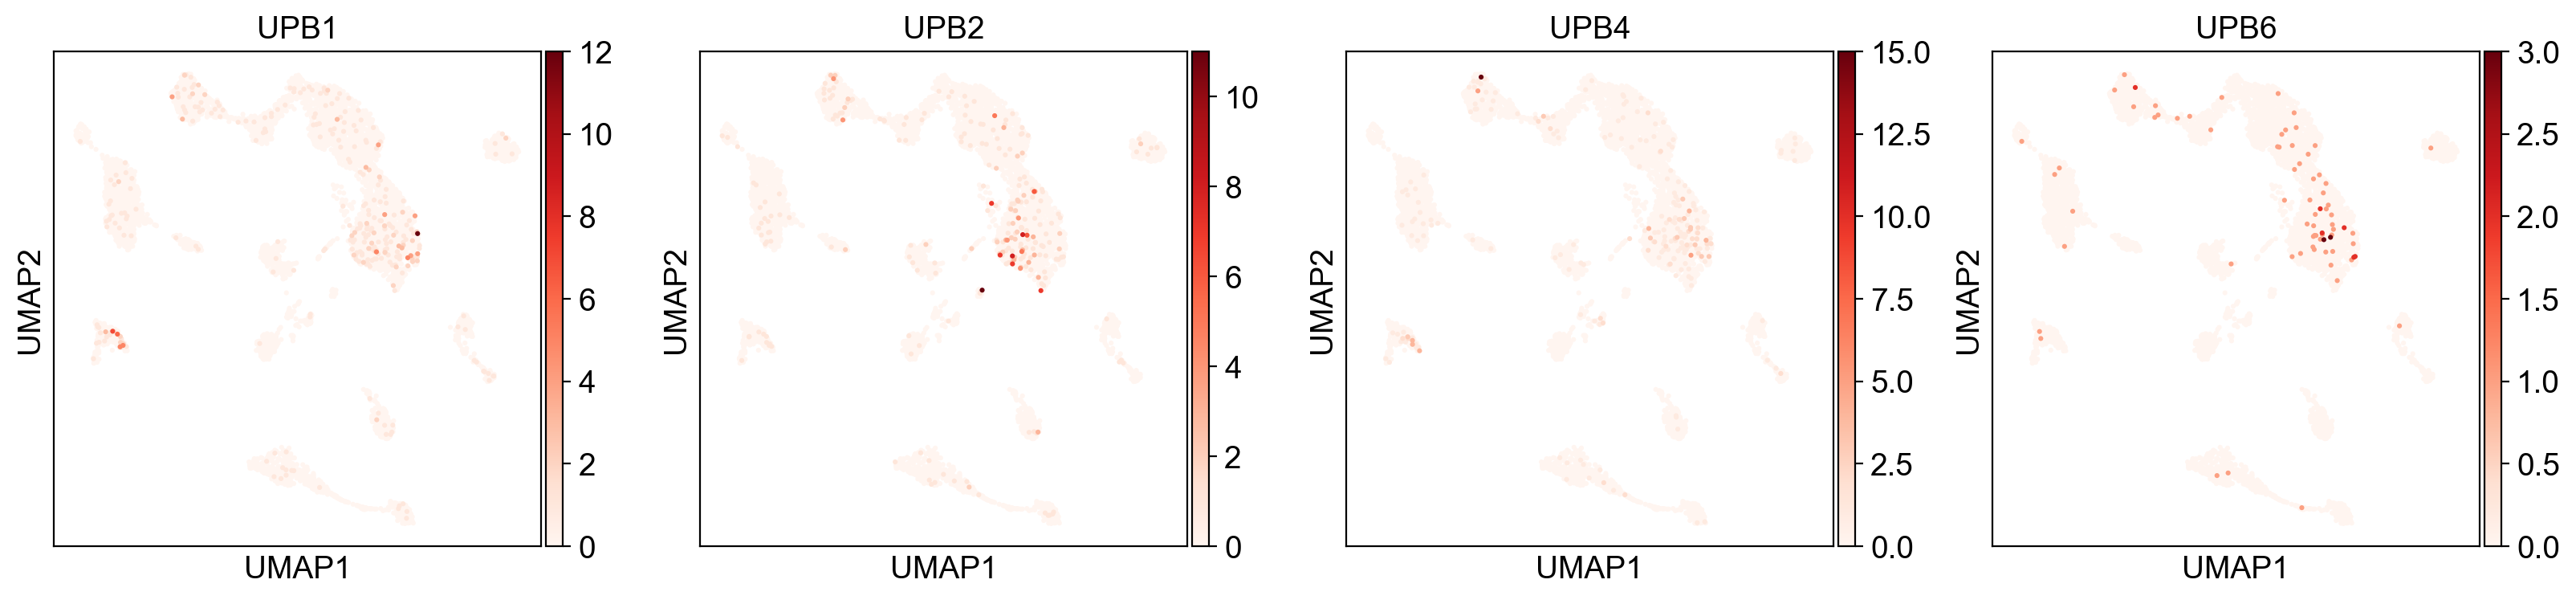

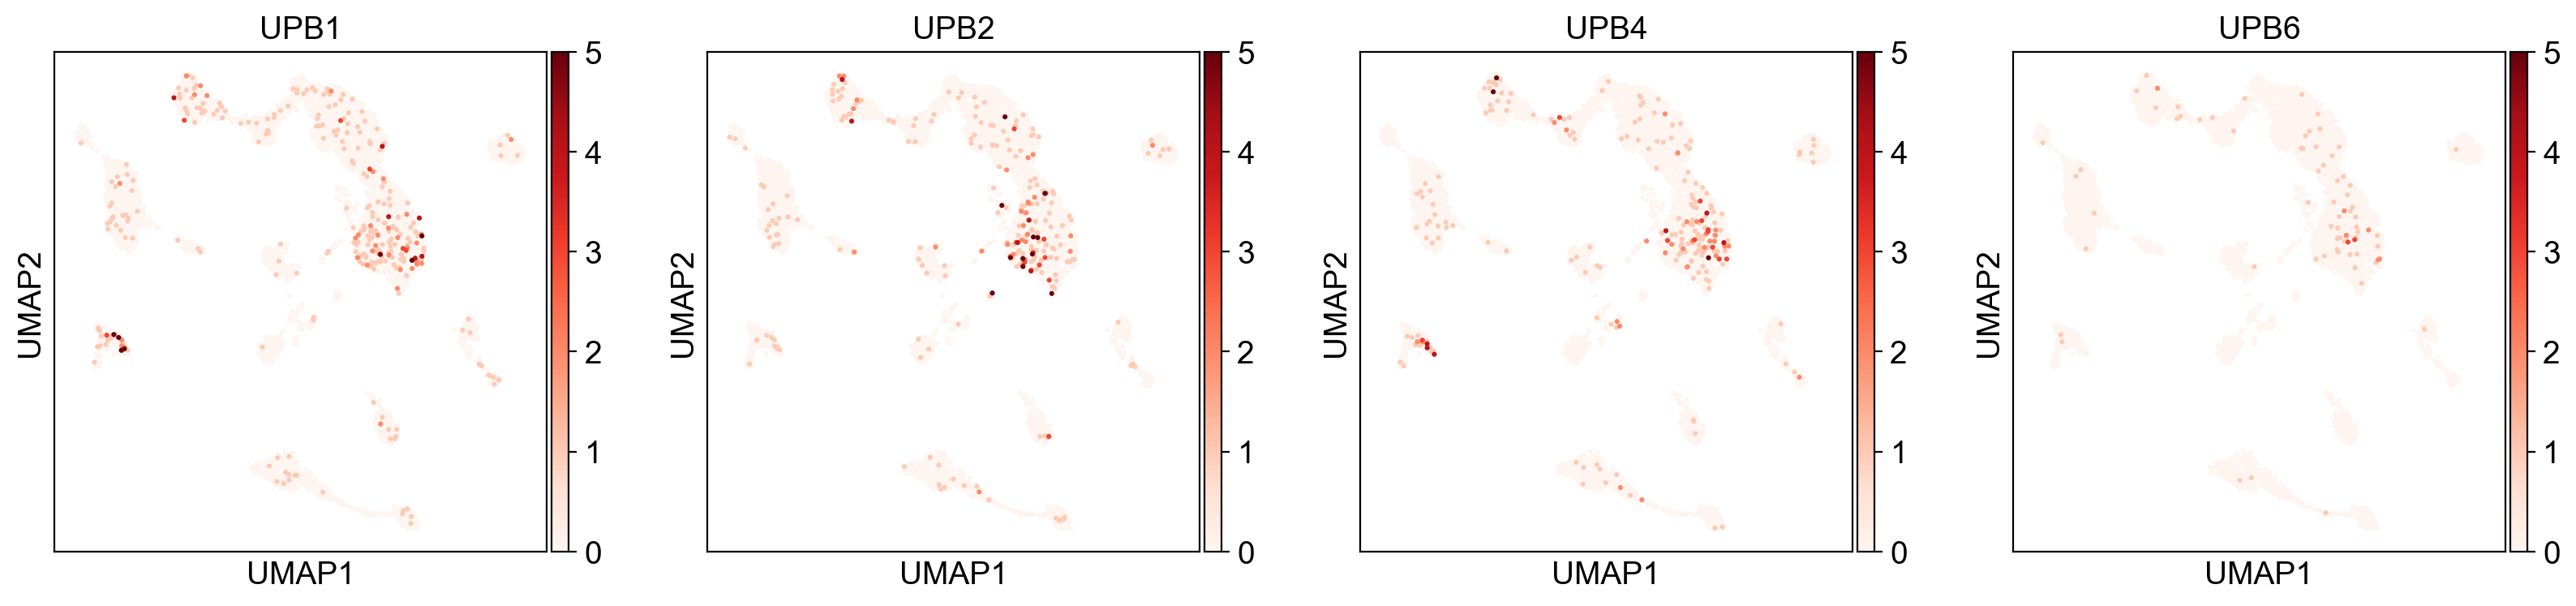

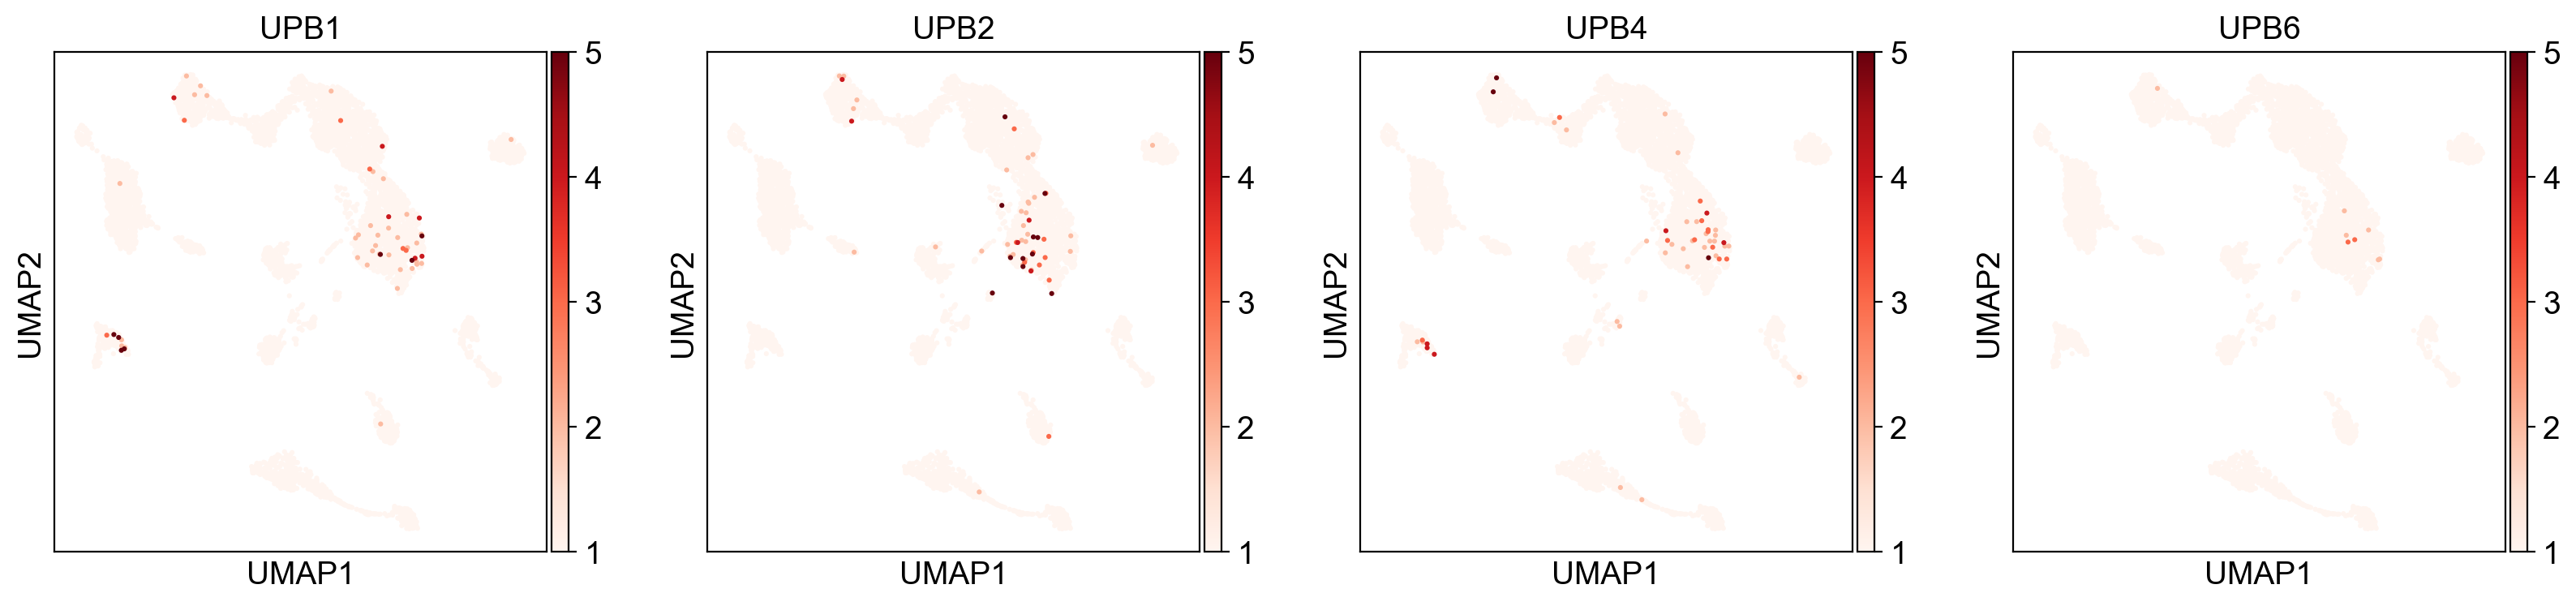

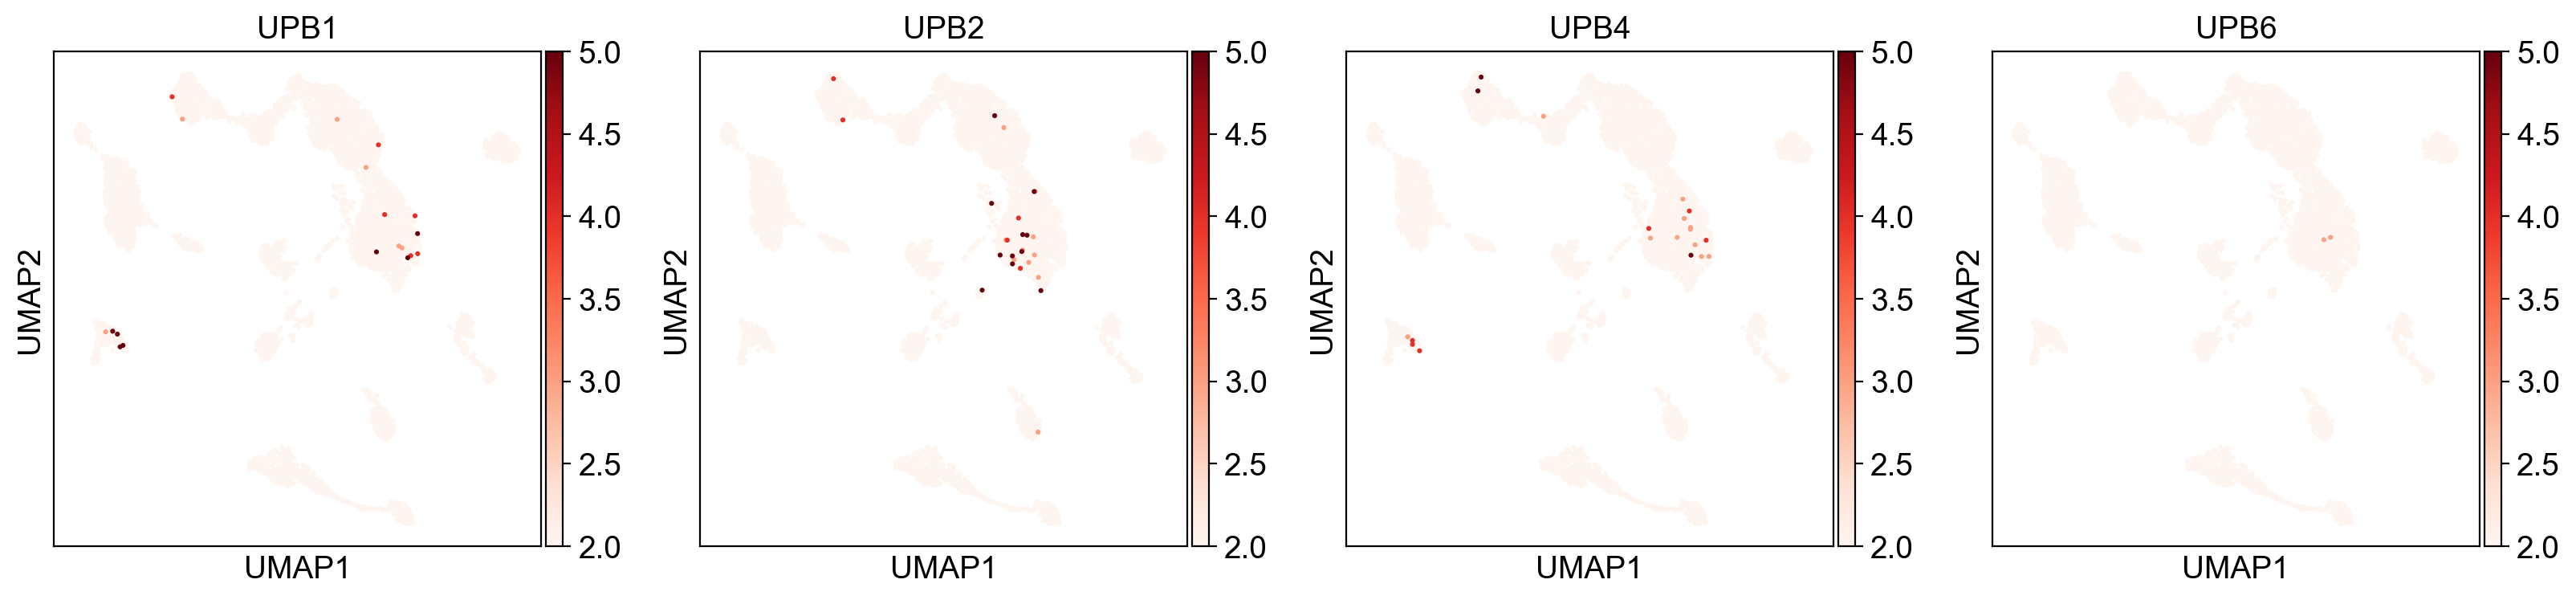

In [30]:
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmax=1)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds")
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmax=5)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmin=1, vmax=5)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmin=2, vmax=5)

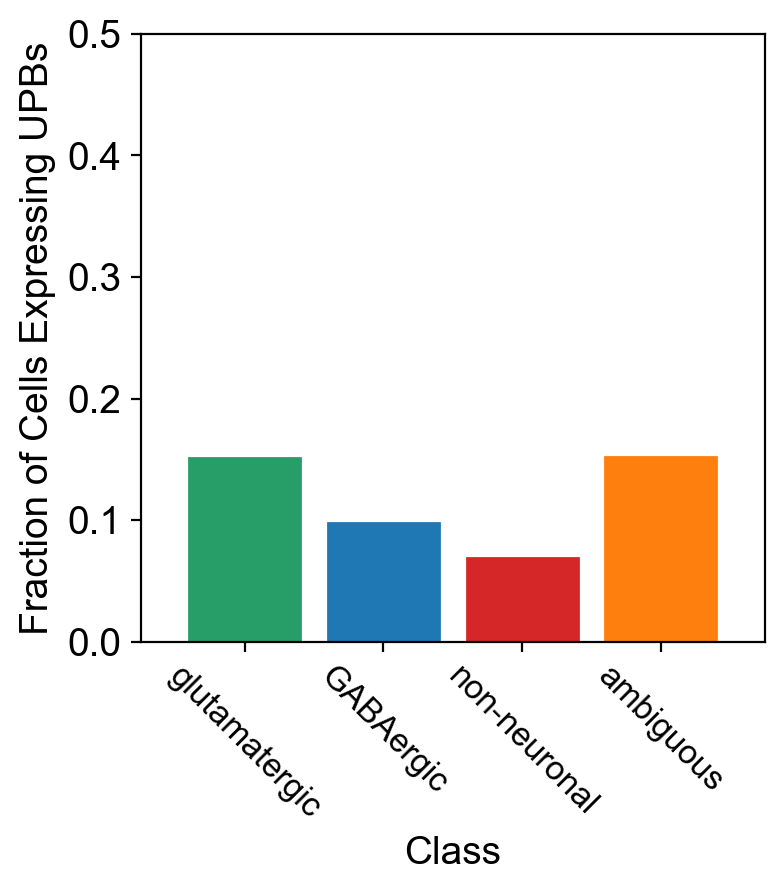

In [31]:
class_ids = ["glutamatergic", "GABAergic", "non-neuronal", "ambiguous"]
class_fractions = []
for clss in class_ids:
    adata_class = adata[adata.obs["class"] == clss, :]
    upbs = np.sum(np.array(adata_class.obs[["UPB1", "UPB2", "UPB4", "UPB6"]]), axis=1) > 0
    class_fractions.append(np.sum(upbs) / adata_class.shape[0])

fig, ax = plt.subplots()
col = [adata.uns["class_colors"][idx] for idx in [2, 0, 3, 1]]
ax.bar(class_ids, class_fractions, color=col, edgecolor=col)
ax.set_xlabel("Class")
ax.set_xlim((-0.75, len(class_ids) - 0.25))
ax.set_xticks(class_ids)
ax.set_xticklabels(class_ids, fontsize=12, rotation=-45)
ax.set_ylabel("Fraction of Cells Expressing UPBs")
ax.set_ylim((0, 0.5))
ax.grid(False)
fig.set_size_inches(4, 4)
plt.show(block=False)

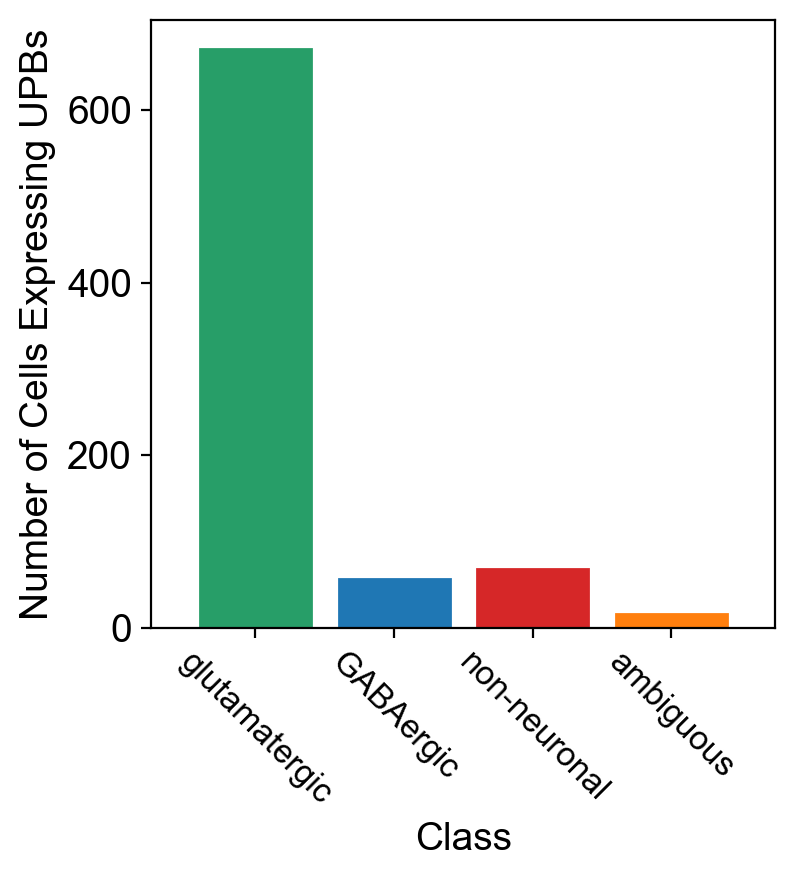

In [32]:
class_ids = ["glutamatergic", "GABAergic", "non-neuronal", "ambiguous"]
class_fractions = []
for clss in class_ids:
    adata_class = adata[adata.obs["class"] == clss, :]
    upbs = np.sum(np.array(adata_class.obs[["UPB1", "UPB2", "UPB4", "UPB6"]]), axis=1) > 0
    class_fractions.append(np.sum(upbs))

fig, ax = plt.subplots()
col = [adata.uns["class_colors"][idx] for idx in [2, 0, 3, 1]]
ax.bar(class_ids, class_fractions, color=col, edgecolor=col)
ax.set_xlabel("Class")
ax.set_xlim((-0.75, len(class_ids) - 0.25))
ax.set_xticks(class_ids)
ax.set_xticklabels(class_ids, fontsize=12, rotation=-45)
ax.set_ylabel("Number of Cells Expressing UPBs")
# ax.set_ylim((0, 0.5))
ax.grid(False)
fig.set_size_inches(4, 4)
plt.show(block=False)

In [33]:
adata.obs["doublet"] = adata.obs["doublet"].astype(str)
adata.obs["LM"] = adata.obs["LM"].astype(str)
adata.obs["RL"] = adata.obs["RL"].astype(str)
adata.obs

batch doublet  doublet_score  UPB1  UPB2   
AAACCCAAGACTTAAG-1-Barcode-1  Barcode-1       0       0.002931   0.0   0.0  \
AAACCCAAGTATTGCC-1-Barcode-1  Barcode-1       0       0.072750   0.0   0.0   
AAACGAAAGACGCTCC-1-Barcode-1  Barcode-1       0       0.003867   0.0   0.0   
AAACGAACATGATAGA-1-Barcode-1  Barcode-1       0       0.023862   1.0   0.0   
AAACGAATCCAGTGTA-1-Barcode-1  Barcode-1       0       0.003393   0.0   0.0   
...                                 ...     ...            ...   ...   ...   
TTTGTTGCACGGCACT-1-Barcode-2  Barcode-2       0       0.044438   0.0   0.0   
TTTGTTGGTGAATGAT-1-Barcode-2  Barcode-2       0       0.080391   0.0   0.0   
TTTGTTGGTGGTCCCA-1-Barcode-2  Barcode-2       0       0.040552   0.0   0.0   
TTTGTTGGTTGATGTC-1-Barcode-2  Barcode-2       0       0.048758   0.0   0.0   
TTTGTTGTCGACGATT-1-Barcode-2  Barcode-2       0       0.037037   0.0   0.0   

                              UPB4  UPB6     LM     RL UPBs VISs  TGs   
AAACCCAAGACTTAAG-1-Barcode-1   0.0   0.0  False  False  NaN  NaN  NaN  \
AAACCCAAGTATTGCC-1-Barcode-1   0.0   0.0  False  False  NaN  NaN  NaN   
AAACGAAAGACGCTCC-1-Barcode-1   0.0   0.0  False  False  NaN  NaN  NaN   
AAACGAACATGATAGA-1-Barcode-1   0.0   0.0   True  False    1   LM  UPB   
AAACGAATCCAGTGTA-1-Barcode-1   0.0   0.0  False  False  NaN  NaN  NaN   
...                            ...   ...    ...    ...  ...  ...  ...   
TTTGTTGCACGGCACT-1-Barcode-2   0.0   0.0  False  False  NaN  NaN  NaN   
TTTGTTGGTGAATGAT-1-Barcode-2   0.0   0.0  False  False  NaN  NaN  NaN   
TTTGTTGGTGGTCCCA-1-Barcode-2   0.0   0.0  False  False  NaN  NaN  NaN   
TTTGTTGGTTGATGTC-1-Barcode-2   1.0   0.0   True  False    4   LM  UPB   
TTTGTTGTCGACGATT-1-Barcode-2   0.0   0.0  False  False  NaN  NaN  NaN   

                              tdTomato  n_genes  percent_mito   n_UMIs   
AAACCCAAGACTTAAG-1-Barcode-1       0.0     3059      0.875612   7766.0  \
AAACCCAAGTATTGCC-1-Barcode-1       0.0     6286      0.072458  37263.0   
AAACGAAAGACGCTCC-1-Barcode-1       0.0     3090      0.382305   7324.0   
AAACGAACATGATAGA-1-Barcode-1       0.0     3942      0.166759  12593.0   
AAACGAATCCAGTGTA-1-Barcode-1       0.0     2602      0.431241   6261.0   
...                                ...      ...           ...      ...   
TTTGTTGCACGGCACT-1-Barcode-2       0.0     5320      0.171512  23905.0   
TTTGTTGGTGAATGAT-1-Barcode-2       0.0     4845      0.092774  19402.0   
TTTGTTGGTGGTCCCA-1-Barcode-2       0.0     3517      0.057698  10399.0   
TTTGTTGGTTGATGTC-1-Barcode-2       0.0     5555      0.280875  23854.0   
TTTGTTGTCGACGATT-1-Barcode-2       0.0     3312      0.210918   8060.0   

                              n_counts leiden          class  
AAACCCAAGACTTAAG-1-Barcode-1    7766.0     12   non-neuronal  
AAACCCAAGTATTGCC-1-Barcode-1   37263.0      3  glutamatergic  
AAACGAAAGACGCTCC-1-Barcode-1    7324.0     12   non-neuronal  
AAACGAACATGATAGA-1-Barcode-1   12591.0      5  glutamatergic  
AAACGAATCCAGTGTA-1-Barcode-1    6260.0     10   non-neuronal  
...                                ...    ...            ...  
TTTGTTGCACGGCACT-1-Barcode-2   23904.0      2  glutamatergic  
TTTGTTGGTGAATGAT-1-Barcode-2   19401.0      2  glutamatergic  
TTTGTTGGTGGTCCCA-1-Barcode-2   10399.0      2  glutamatergic  
TTTGTTGGTTGATGTC-1-Barcode-2   23852.0      4  glutamatergic  
TTTGTTGTCGACGATT-1-Barcode-2    8060.0      6  glutamatergic  

[6099 rows x 19 columns]

Save Classes Separately

In [31]:
save_path = "E:/Projection-seq/"

adata_raw.obs = adata.obs
adata_raw.write_h5ad(save_path + "Projection_Seq_Split_All.h5ad")

adata.write_h5ad(save_path + "Projection_Seq_Split_All_Clustered.h5ad")

for classname, filename in zip(["glutamatergic", "GABAergic", "non-neuronal"], ["Glut", "GABA", "Non"]):
    
    adata_class = adata_raw[adata_raw.obs["class"] == classname, :]
    del adata_class.uns
    del adata_class.obsm
    del adata_class.varm
    del adata_class.obsp
    adata_class.var = adata_class.var[["gene_ids", "feature_types", "genome"]]

    adata_class.write_h5ad(save_path + "Projection_Seq_Split_" + filename + ".h5ad")